# Imports

In [1]:
# ==============================================================================
# Imports
# ==============================================================================
import os
import time
IS_COLAB = any(var.startswith("COLAB_") for var in os.environ)

if IS_COLAB:
  print("Running in Google Colab...")
  print("Installing libraries...")
  os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
  %pip install pytorch-msssim lpips --no-deps -q
  %pip install wandb seaborn -qU
  print("Libraries installed.")

else:
  print("Not running in Google Colab.")

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as torch_utils
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from pytorch_msssim import ssim
from lpips import LPIPS
from einops import rearrange, repeat
import numpy as np
import random
import math

# Image Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.measure import label, regionprops
from skimage import measure
import cv2

# Metrics and Evaluation
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from skimage import measure

# Datasets and Logging
import kagglehub
import wandb

Running in Google Colab...
Installing libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.9 MB/s eta 0:00:00
Libraries installed.


# Configuration

In [2]:

# ==============================================================================
# Globals (Configuration)
# ==============================================================================
# General configurations
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 71
TRAIN_MODEL = True #true if we want to train, false if we only want to do inference
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if DEVICE.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True
else:
    torch.backends.cudnn.enabled = False

# Dataset paths and directories

BASE_PATH = ''
MVTEC_DATA_DIR = ''
BTAD_DATA_DIR = ''
MODEL_SAVE_DIR = ''
DATASET_DIR = ''
NUM_WORKERS_PARAM = { # a 0 un poco più lento ma possiamo usare anche la T4 e la L4
        'num_workers': 0
}

# wandb login - requires API key
try:
    wandb.login()
except Exception as e:
    print(f"Wandb login failed or skipped: {e}")
    print("Please log in to wandb manually if needed.")

if IS_COLAB:
    from google.colab import drive, runtime
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
    print("Google Drive mounted.")
    BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/'
    MODEL_SAVE_DIR = os.path.join(BASE_PATH, 'trained_models')
    DATASET_DIR = os.path.join(BASE_PATH, 'datasets')
    MVTEC_DATA_DIR = os.path.join(DATASET_DIR, 'mvtec')
    BTAD_DATA_DIR = os.path.join(DATASET_DIR, 'btad')

else:
    BASE_PATH = os.path.dirname(os.curdir) #os.path.abspath('.')
    MODEL_SAVE_DIR = os.path.join(BASE_PATH, 'trained_models')
    DATASET_DIR = os.path.join(BASE_PATH, 'datasets')

    # Download MVTEC and BTAD dataset
    MVTEC_DATA_DIR = kagglehub.dataset_download("ipythonx/mvtec-ad", force_download=False)
    BTAD_DATA_DIR = kagglehub.dataset_download("thtuan/btad-beantech-anomaly-detection", force_download=False)

if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR, exist_ok=True)

print("-" * 30)
print("Paths Configuration:")
print(f"BASE_PATH: {BASE_PATH}")
print(f"MODEL_SAVE_DIR: {MODEL_SAVE_DIR}")
print(f"DATASET_DIR: {DATASET_DIR}") #TODO implement a function to download the datasets if they are not present, and use the cached ones.
print(f"MVTEC_DATA_DIR: {MVTEC_DATA_DIR}")
print(f"BTAD_DATA_DIR: {BTAD_DATA_DIR}")
print("-" * 30)

# Model configurations - Aligned with VT-ADL paper (https://github.com/pankajmishra000/VT-ADL)
IMG_SIZE = 512            # Target image size (VT-ADL use 512)
PATCH_SIZE = 64           # Patch size for ViT
IN_CHANNELS = 3           # Input image channels (RGB)
EMBED_DIM = 512           # Embedding dimension for ViT (as in VT-ADL paper decoder section on page 2) [before it was 768]
NUM_HEADS = 8             # Number of attention heads (as in VT-ADL implementation VT_AE.py)
NUM_LAYERS = 6            # Number of transformer layers [encoder blocks] (as in VT-ADL implementation)
MLP_HIDDEN_DIM = 1024     # Size of MLP hidden dimension(as in VT-ADL paper implementation)
DROPOUT_RATE = 0.0        # VT-ADL paper mentioned not using dropout for GMDN stability
DIGCAP_SIZE = 8*8         # Il numero di tipi diversi di capsule primarie per ogni posizione spaziale.

# Training configurations - Aligned with VT-ADL paper
BATCH_SIZE = 8            # Adjust based on GPU memory
LEARNING_RATE = 1e-4
NUM_GAUSSIANS = 150       # Number of Gaussian components for GMDN (VT-ADL used 150)
NUM_EPOCHS = 400          # VT-ADL used 400 epochs (Adjust for faster testing)
WEIGHT_DECAY = 1e-4
LAMBDA_MSE = 5.0          # Weight for MSE loss (VT-ADL used 5.0)
LAMBDA_SSIM = 0.5         # Weight for SSIM loss (VT-ADL used 0.5)
LAMBDA_GMDN = 1.0         # Weight for GMDN loss (VT-ADL used 1.0, representing -LL)
LAMBDA_LPIPS = 0.0       # Weight for LPIPS loss (NEW!!! we start with 1.0, reduced to 0.5, and now 0.25)

# DyT specific - from LeCun paper init
DYT_INIT_A = 0.5

# General Configuration
USING_DYT = False      # False if using Normalization Layer
USING_MVTEC = False    # False if using BTAD

# --- Derived Configurations ---
CONF_STR = "DyT" if USING_DYT else "LayerNorm"
DATASET_STR = "MVTEC" if USING_MVTEC else "BTAD"
DATASET_CAT_STR = "bottle" if USING_MVTEC else '01' # Example: 'bottle', 'cable', 'hazelnut' for MVTec; '01', '02', '03' for BTAD

# Model Comparison (Set to False initially)
COMPARE_MODELS = False  # True if you want to compare pre-trained models
# Define model names/paths if COMPARE_MODELS is True
DYT_MODEL_NAME_MVTEC = "" # e.g., "vt_adl_dyt_epoch_400_exp_name_db_mvtec.pth.tar"
LN_MODEL_NAME_MVTEC = ""
DYT_MODEL_NAME_BTAD = ""
LN_MODEL_NAME_BTAD = ""

print("-" * 30)
print("Run Configuration:")
print(f"Normalization: {CONF_STR}")
print(f"Dataset: {DATASET_STR}")
print(f"Category: {DATASET_CAT_STR}")
print(f"Image Size: {IMG_SIZE}")
print(f"Patch Size: {PATCH_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Train Model: {TRAIN_MODEL}")
print(f"Compare Models: {COMPARE_MODELS}")
print("-" * 30)

Using GPU: NVIDIA L4


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: onogab (CV_albe_gab_kri) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted.
------------------------------
Paths Configuration:
BASE_PATH: /content/drive/MyDrive/Colab Notebooks/Computer Vision/
MODEL_SAVE_DIR: /content/drive/MyDrive/Colab Notebooks/Computer Vision/trained_models
DATASET_DIR: /content/drive/MyDrive/Colab Notebooks/Computer Vision/datasets
MVTEC_DATA_DIR: /content/drive/MyDrive/Colab Notebooks/Computer Vision/datasets/mvtec
BTAD_DATA_DIR: /content/drive/MyDrive/Colab Notebooks/Computer Vision/datasets/btad
------------------------------
------------------------------
Run Configuration:
Normalization: LayerNorm
Dataset: BTAD
Category: 01
Image Size: 512
Patch Size: 64
Batch Size: 8
Epochs: 400
Train Model: True
Compare Models: False
------------------------------


# Utils

In [3]:
# ==============================================================================
# Utils - Helper functions
# ==============================================================================
class Utils:
    @staticmethod
    def show_image(tensor_img, title=""):
        """Displays a tensor image."""
        if tensor_img.is_cuda:
            tensor_img = tensor_img.cpu()
        img = tensor_img.detach().squeeze().permute(1, 2, 0).numpy()
        # Denormalize if necessary, or clip to [0, 1]
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
        try:
          wandb.summary[title] = wandb.Image(plt)
        except Exception as e:
          print(f"Wandb logging failed for image '{title}': {e}")
        plt.show()

    @staticmethod
    def save_checkpoint(state, filename="checkpoint.pth.tar"):
        """Saves checkpoint."""
        print("=> Saving checkpoint")
        torch.save(state, filename)

    @staticmethod
    def load_checkpoint(checkpoint_path, model, optimizer=None):
        """Loads checkpoint."""
        print("=> Loading checkpoint")
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        try:
          model.load_state_dict(checkpoint['state_dict'])
        except Exception as e:
          print(f"Error loading state_dict checkpoint {e}")
        if optimizer:
            print("=> Loading optimizer")
            try:
              optimizer.load_state_dict(checkpoint['optimizer'])
            except Exception as e:
              print(f"Error loading optimizer checkpoint {e}")
        return checkpoint.get('epoch', 0) #robust loading data from last epoch.

    @staticmethod
    def calculate_ssim_loss(img1, img2, data_range=1.0, window_size=11):
        """
        Calculates 1 - SSIM as a loss.
        Higher SSIM (1.0) means higher similarity, so we use 1.0 - SSIM as the loss.

        Args:
            img1, img2: Input images (batches of tensors)
            data_range: Maximum value range of images (usually 1.0 or 255)
            window_size: Size of the gaussian filter window

        Returns:
            A scalar loss value (lower is better)
        """
        if img1.device != img2.device:
            img2 = img2.to(img1.device)

        # Ensure input dimensions are correct (N,C,H,W format)
        if img1.dim() == 3:
            img1 = img1.unsqueeze(0)
        if img2.dim() == 3:
            img2 = img2.unsqueeze(0)

        if img1.shape != img2.shape:
            raise ValueError(f"Input images must have the same shape but got {img1.shape} and {img2.shape}")

        # Calculate SSIM (returns value between 0 and 1, where 1 is perfect similarity)
        ssim_value = ssim(
            img1,
            img2,
            data_range=data_range,
            size_average=True,  # Return a scalar
            win_size=window_size,  # Gaussian filter size
            K=(0.01, 0.03),  # Default constants
            nonnegative_ssim=True  # to constrain the values between 0 and 1
        )

        # Convert to loss (lower is better)
        return 1.0 - ssim_value



    @staticmethod
    def plot_loss(losses, n_epochs, title):
        """Plots the training loss over epochs."""
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, n_epochs + 1), losses)
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    @staticmethod
    def log_wandb_classification_report(report):
        """
        Logs classification report to wandb.
        Args:
            y_true: True labels
            y_pred: Predicted labels
            class_names: List of class names
        """
        if not wandb.run:
          return

        for metric, value in report.items():
            wandb.summary[metric] = value

    @staticmethod
    def visualize_model_results(results):
        """
        Create visualizations of model evaluation results and return the plot objects.

        Parameters:
        -----------
        results : dict
            Dictionary where keys are model names and values are dictionaries of metrics.
            Each model's dictionary should contain metrics and 'evaluation_time'.

        Returns:
        --------
        matplotlib.figure.Figure
            The figure object containing the visualization
        """
        # Set a nice aesthetic style
        sns.set_style("whitegrid")

        # Extract model names and metrics
        model_names = list(results.keys())
        metrics = {key for model_data in results.values() for key in model_data.keys()}
        metrics = list(metrics - {'evaluation_time'})  # Get all metrics except evaluation time

        # Create subplots: one for eval time, one for metrics
        fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [1, 2]})

        # 1. Plot evaluation time
        eval_times = [results[model]['evaluation_time'] for model in model_names]
        ax1 = axes[0]
        bars = ax1.bar(model_names, eval_times, color=sns.color_palette("viridis", len(model_names)))
        ax1.set_title('Model Evaluation Time', fontsize=16)
        ax1.set_ylabel('Time (seconds)', fontsize=14)
        ax1.set_xlabel('Models', fontsize=14)
        ax1.tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}s', ha='center', va='bottom')

        # 2. Plot performance metrics
        ax2 = axes[1]
        x = np.arange(len(model_names))
        bar_width = 0.8 / len(metrics)
        offset = np.linspace(-0.4 + bar_width/2, 0.4 - bar_width/2, len(metrics))

        for i, metric in enumerate(metrics):
            values = [results[model].get(metric, 0) for model in model_names]
            bars = ax2.bar(x + offset[i], values, bar_width,
                           label=metric, alpha=0.8,
                           color=sns.color_palette("muted", len(metrics))[i])

            # Add value labels on bars
            for j, bar in enumerate(bars):
                height = bar.get_height()
                if height > 0.01:  # Only show values that are visible
                    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

        ax2.set_title('Model Performance Metrics', fontsize=16)
        ax2.set_ylabel('Score', fontsize=14)
        ax2.set_xlabel('Models', fontsize=14)
        ax2.set_xticks(x)
        ax2.set_xticklabels(model_names, rotation=45, ha='right')
        ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
        ax2.set_ylim(0, 1.0)  # Assuming metrics are between 0 and 1

        # Identify MVTec and BTAD models for annotations
        mvtec_models = [model for model in model_names if "mvtec" in model]
        btad_models = [model for model in model_names if "mvtec" not in model]

        # Add dataset annotations if there are clearly separated models
        if mvtec_models and btad_models:
            mvtec_indices = [model_names.index(model) for model in mvtec_models]
            btad_indices = [model_names.index(model) for model in btad_models]

            if min(mvtec_indices) > max(btad_indices) or max(mvtec_indices) < min(btad_indices):
                # Models are grouped by dataset - we can add dividers
                divider_x = (max(mvtec_indices) + min(btad_indices))/2 if min(mvtec_indices) > max(btad_indices) else (max(btad_indices) + min(mvtec_indices))/2
                for ax in axes:
                    ax.axvline(x=divider_x - 0.5, color='gray', linestyle='--', alpha=0.5)

                    if min(mvtec_indices) < min(btad_indices):
                        ax.text(np.mean(mvtec_indices), ax.get_ylim()[1]*0.95, "MVTec Models", ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
                        ax.text(np.mean(btad_indices), ax.get_ylim()[1]*0.95, "BTAD Models", ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
                    else:
                        ax.text(np.mean(btad_indices), ax.get_ylim()[1]*0.95, "BTAD Models", ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
                        ax.text(np.mean(mvtec_indices), ax.get_ylim()[1]*0.95, "MVTec Models", ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

        plt.tight_layout()
        fig.suptitle('Model Evaluation Results Comparison', fontsize=18, y=0.98)
        plt.subplots_adjust(top=0.9, bottom=0.15)

        return fig


# Dataset Loading

In [4]:
# ==============================================================================
# Data - Dataset loading and preprocessing
# ==============================================================================
class BaseAnomalyDataset(Dataset):
    """Base class for anomaly detection datasets."""

    def __init__(self, img_size=512):
        """
        Initialize the base anomaly dataset.

        Args:
            img_size (int): Target image size
        """
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #ImageNet normalization
        ])

        self.image_paths = []
        self.mask_paths = []

    def __len__(self):
        return len(self.image_paths)

    def _load_mask(self, mask_path, image_shape):
        """
        Load and process a mask image.

        Args:
            mask_path (str): Path to the mask image
            image_shape (tuple): Shape of the corresponding image

        Returns:
            torch.Tensor: Processed mask tensor
        """
        if mask_path is None:
            # Create an empty mask
            mask = torch.zeros((1, image_shape[1], image_shape[2]))
            return mask

        try:
            mask_pil = Image.open(mask_path).convert("L")  # Grayscale mask
            mask = self.transform(mask_pil)
            mask = (mask > 0.5).float()  # Binarize
            return mask
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            # Return empty mask on error
            return torch.zeros((1, image_shape[1], image_shape[2]))

In [5]:
class MVTecDataset(BaseAnomalyDataset):
    """Dataset class for MVTec Anomaly Detection dataset."""

    def __init__(self, data_dir, category, split="train", img_size=512):
        """
        Initialize MVTec dataset.

        Args:
            data_dir (str): Path to MVTec dataset
            category (str): Category name (e.g., 'bottle', 'cable')
            split (str): 'train' or 'test'
            img_size (int): Target image size
        """
        super().__init__(img_size)
        self.data_dir = data_dir
        self.category = category
        self.split = split.lower()
        self.transform = transforms.Compose([
            transforms.Resize((550, 550)),
            transforms.CenterCrop((img_size, img_size)),
            transforms.ToTensor(),
        ])

        self._load_data()

    def _load_data(self):
        """Load data paths based on dataset structure."""
        category_path = os.path.join(self.data_dir, self.category)

        if self.split == "train":
            # Training set contains only 'good' (normal) images
            image_folder = os.path.join(category_path, "train", "good")

            if os.path.exists(image_folder):
                for img_name in os.listdir(image_folder):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
                        self.image_paths.append(os.path.join(image_folder, img_name))
                        self.mask_paths.append(None)  # No masks for normal training images
            else:
                raise ValueError(f"Training folder not found: {image_folder}")

        elif self.split == "test":
            # Test set contains 'good' and anomalous images
            image_folder = os.path.join(category_path, "test")
            mask_folder = os.path.join(category_path, "ground_truth")

            if not os.path.exists(image_folder):
                raise ValueError(f"Test folder not found: {image_folder}")

            # Iterate through subfolders (e.g., good, broken_large, etc.)
            for subfolder_name in os.listdir(image_folder):
                subfolder_path = os.path.join(image_folder, subfolder_name)
                if os.path.isdir(subfolder_path):
                    for img_name in os.listdir(subfolder_path):
                        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
                            self.image_paths.append(os.path.join(subfolder_path, img_name))

                            if subfolder_name != "good":  # Anomalous images have masks
                                mask_name = img_name.split('.')[0] + "_mask.png"
                                mask_path = os.path.join(mask_folder, subfolder_name, mask_name)
                                self.mask_paths.append(mask_path)
                            else:
                                self.mask_paths.append(None)
        else:
            raise ValueError(f"Split '{self.split}' not supported. Use 'train' or 'test'.")

    def __getitem__(self, idx):
        """Get a sample from the dataset."""
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # For training, only images are needed
        if self.split == "train":
            return image

        # For testing, return image, mask, and label
        mask_path = self.mask_paths[idx]
        mask = self._load_mask(mask_path, image.shape)

        # Image is anomalous if it has a mask
        img_label = 1 if mask_path is not None else 0

        return image, mask, img_label


In [6]:
class BTADDataset(BaseAnomalyDataset):
    """Dataset class for BTAD Anomaly Detection dataset."""

    def __init__(self, data_dir, category, split="train", img_size=256):
        """
        Initialize BTAD dataset.

        Args:
            data_dir (str): Path to BTAD dataset
            category (str): Category name (e.g., '01', '02', '03')
            split (str): 'train' or 'test'
            img_size (int): Target image size
        """
        super().__init__(img_size)
        self.data_dir = data_dir
        self.category = category
        self.split = split.lower()

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

        self._load_data()

    def _load_data(self):
        """Load data paths based on dataset structure."""
        product_path = os.path.join(self.data_dir, self.category)

        if self.split == "train":
            # Training set contains only normal ('ok') images
            image_folder = os.path.join(product_path, "train", "ok")

            if os.path.exists(image_folder):
                for img_name in os.listdir(image_folder):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', 'bmp')):
                        self.image_paths.append(os.path.join(image_folder, img_name))
                        self.mask_paths.append(None)  # No masks for normal training images
            else:
                raise ValueError(f"Training folder not found: {image_folder}")

        elif self.split == "test":
            # Test set contains normal ('ok') and anomalous ('ko') images
            image_folder_ok = os.path.join(product_path, "test", "ok")
            image_folder_ko = os.path.join(product_path, "test", "ko")
            mask_folder_ko = os.path.join(product_path, "ground_truth", "ko")

            # Add normal images
            if os.path.exists(image_folder_ok):
                for img_name in os.listdir(image_folder_ok):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', 'bmp')):
                        self.image_paths.append(os.path.join(image_folder_ok, img_name))
                        self.mask_paths.append(None)  # No masks for normal images

            # Add anomalous images
            if os.path.exists(image_folder_ko):
                for img_name in os.listdir(image_folder_ko):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', 'bmp')):
                        self.image_paths.append(os.path.join(image_folder_ko, img_name))

                        base_name = os.path.splitext(img_name)[0]
                        # Mask path is the same as image name in ko_mask folder
                        mask_path = os.path.join(mask_folder_ko, base_name + '.png')
                        if os.path.exists(mask_path):
                          self.mask_paths.append(mask_path)
                        else:
                          self.mask_paths.append(None)

            if len(self.image_paths) == 0:
                raise ValueError(f"No test images found in {image_folder_ok} or {image_folder_ko}")
        else:
            raise ValueError(f"Split '{self.split}' not supported. Use 'train' or 'test'.")

    def __getitem__(self, idx):
        """Get a sample from the dataset."""
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # For training, only images are needed
        if self.split == "train":
            return image

        # For testing, return image, mask, and label
        mask_path = self.mask_paths[idx]
        mask = self._load_mask(mask_path, image.shape)

        # Image is anomalous if it has a mask
        img_label = 1 if mask_path is not None else 0

        return image, mask, img_label

# Network Components

In [7]:
# ==============================================================================
# Network - Core model components
# ==============================================================================

## LW_SSIM Loss

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LWSSIMLoss(nn.Module):
    """
    Level Weighted Structural Similarity Loss with improved numerical stability
    to prevent NaN errors during backpropagation.
    """
    def __init__(self, filter_sizes=[11, 9, 7, 5, 3], filter_weights=None,
                 data_range=1.0, alpha=1.0, beta=1.0, gamma=1.0,
                 C1=0.01**2, C2=0.03**2, C3=None, eps=1e-8):
        super(LWSSIMLoss, self).__init__()

        # Filter sizes for different scales
        self.filter_sizes = filter_sizes
        self.num_levels = len(filter_sizes)

        # Default to equal weighting if not specified
        if filter_weights is None:
            self.filter_weights = torch.ones(self.num_levels) / self.num_levels
        else:
            self.filter_weights = torch.tensor(filter_weights)
            # Normalize weights to sum to 1
            self.filter_weights = self.filter_weights / self.filter_weights.sum()

        self.register_buffer('weights', self.filter_weights)

        # Component weights
        self.alpha = alpha  # Luminance weight
        self.beta = beta    # Contrast weight
        self.gamma = gamma  # Structure weight

        # Constants to avoid division by zero
        self.C1 = C1
        self.C2 = C2
        self.C3 = C3 if C3 is not None else C2/2

        # Epsilon for numerical stability
        self.eps = eps

        self.data_range = data_range

        # Create and register Gaussian windows individually
        for size in filter_sizes:
            # Create Gaussian window and register it as a buffer with a unique name
            window = self._create_gaussian_window(size)
            self.register_buffer(f'window_{size}', window)

    def _create_gaussian_window(self, window_size, sigma=1.5):
        """
        Create a 2D Gaussian window for filtering.
        """
        # Create a 1D Gaussian kernel
        coords = torch.arange(window_size, dtype=torch.float)
        coords -= window_size // 2

        # Gaussian function
        gauss = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
        gauss /= gauss.sum()

        # Create 2D Gaussian kernel by outer product
        kernel = gauss.unsqueeze(0) * gauss.unsqueeze(1)

        # Normalize
        kernel /= kernel.sum()

        # Reshape to [1, 1, window_size, window_size] for conv2d operation
        return kernel.unsqueeze(0).unsqueeze(0)

    def _get_window(self, window_size):
        """Get the Gaussian window for the given size."""
        return getattr(self, f'window_{window_size}')

    def _compute_ssim_components(self, x, y, window_size):
        """
        Compute the luminance, contrast, and structure components of SSIM
        with improved numerical stability.
        """
        window = self._get_window(window_size)
        padding = window_size // 2

        # Expand window to match input channels
        channel_window = window.expand(x.shape[1], 1, window_size, window_size)

        # Calculate means for each channel
        mu_x = F.conv2d(x, channel_window, padding=padding, groups=x.shape[1])
        mu_y = F.conv2d(y, channel_window, padding=padding, groups=y.shape[1])

        mu_x_sq = mu_x ** 2
        mu_y_sq = mu_y ** 2
        mu_xy = mu_x * mu_y

        # Calculate variances and covariance
        sigma_x_sq = F.conv2d(x ** 2, channel_window, padding=padding, groups=x.shape[1]) - mu_x_sq
        sigma_y_sq = F.conv2d(y ** 2, channel_window, padding=padding, groups=y.shape[1]) - mu_y_sq
        sigma_xy = F.conv2d(x * y, channel_window, padding=padding, groups=x.shape[1]) - mu_xy

        # Apply a stronger clamp to prevent very small negative values from numerical errors
        sigma_x_sq = torch.clamp(sigma_x_sq, min=self.eps)
        sigma_y_sq = torch.clamp(sigma_y_sq, min=self.eps)

        # Compute standard deviations - add eps inside the sqrt for stability
        sigma_x = torch.sqrt(sigma_x_sq)
        sigma_y = torch.sqrt(sigma_y_sq)

        # Luminance comparison
        l = (2 * mu_xy + self.C1) / (mu_x_sq + mu_y_sq + self.C1)

        # Contrast comparison - use stabilized formulation
        c = (2 * sigma_x * sigma_y + self.C2) / (sigma_x_sq + sigma_y_sq + self.C2)

        # Structure comparison - add eps to denominator for stability
        s_numerator = sigma_xy + self.C3
        s_denominator = sigma_x * sigma_y + self.C3
        s = s_numerator / s_denominator

        return l, c, s

    def _compute_lwssim_single_scale(self, x, y, window_size):
        """
        Compute the Level-Weighted SSIM at a single scale.
        """
        l, c, s = self._compute_ssim_components(x, y, window_size)

        # Key difference from standard SSIM:
        # Addition instead of multiplication between luminance and other components
        lwssim = self.alpha * l + self.beta * c * s

        return lwssim

    def forward(self, x, y):
        """
        Compute LWSSIM loss between input and target images.
        """
        # Ensure inputs are in the appropriate range
        if self.data_range != 1.0:
            x = x / self.data_range
            y = y / self.data_range

        # Clamp values for stability
        x = torch.clamp(x, min=0, max=1)
        y = torch.clamp(y, min=0, max=1)

        # Compute multi-scale LWSSIM
        multi_scale_lwssim = 0.0

        for i, window_size in enumerate(self.filter_sizes):
            # Compute LWSSIM at current scale
            lwssim_val = self._compute_lwssim_single_scale(x, y, window_size)

            # Apply weight for this scale
            weight = self.weights[i]
            multi_scale_lwssim += weight * lwssim_val

        # Average across spatial dimensions
        multi_scale_lwssim = multi_scale_lwssim.mean([2, 3])

        # Average across batch and channels
        lwssim_score = multi_scale_lwssim.mean()

        # Convert to loss (1 - score)
        return 1.0 - lwssim_score

## DyT (Dynamic Tanh)

In [9]:
class DyT(nn.Module):
    """ Dynamic Tanh Layer """
    def __init__(self, dim, init_a=DYT_INIT_A):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(init_a, dtype=torch.float32)) #0.5 come il paper di Lecun
        self.gamma = nn.Parameter(torch.ones(dim, dtype=torch.float32) * 0.9) #Come il paper di LeCun, ma gamma leggermente più piccolo
        self.beta = nn.Parameter(torch.zeros(dim, dtype=torch.float32)) #Come il paper di LeCun
        # To ensure gamma and beta can be broadcasted correctly with (B, N, D) input
        # they need to be shaped as (1, 1, D) or (D)
        # PyTorch handles (D) broadcasting to (B,N,D) if op is like self.gamma * tensor

    def forward(self, x):
        # x shape: (batch_size, num_patches, embed_dim)
        return self.gamma * torch.tanh(self.alpha * x) + self.beta

## Attention

In [10]:
class Attention(nn.Module):
    """ Multi-Head Self-Attention """
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        self.scale = dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, mask=None):
        B, N, C = x.shape # Batch, NumPatches, Channels(Dimension)
        #TODO capire qui se le operazioni commentate velocizzano (No in realtà crashano! sistemare?)
        #qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        qkv = self.qkv(x).chunk(3, dim=-1)

        #q, k, v = qkv[0], qkv[1], qkv[2]
        #q, k, v = qkv.unbind(0)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads), qkv)

        #attn = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale #NEW MAGIC
        attn = (q @ k.transpose(-2, -1)) * self.scale #OLD

        if mask is not None:
          mask = F.pad(mask.flatten(1), (1, 0), value = True)
          assert mask.shape[-1] == attn.shape[-1], 'mask has incorrect dimensions'
          mask = mask[:, None, :] * mask[:, :, None]
          mask_value = -torch.finfo(attn.dtype).max # = -1e9
          attn = attn.masked_fill(~mask, mask_value)

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        mask_value = -torch.finfo(attn.dtype).max

        #x = torch.einsum('bhij,bhjd->bhid', attn, v) #NEW MAGIC
        x = (attn @ v).transpose(1, 2).reshape(B, N, C) #OLD
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

## MLP

In [11]:
class MLP(nn.Module):
    """ MLP block """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

## Transformer (Block)

In [12]:
class NormalizationFactory:
    """Factory class for creating normalization layers."""

    @staticmethod
    def create_norm_layer(norm_type, dim, dyt_init_a=0.5):
        """
        Create a normalization layer based on the specified type.

        Args:
            norm_type (str): Type of normalization ('layernorm' or 'dyt')
            dim (int): Dimension of the input features
            dyt_init_a (float): Initial alpha value for DyT

        Returns:
            nn.Module: Normalization layer

        Raises:
            ValueError: If norm_type is not supported
        """
        norm_type = norm_type.lower()

        if norm_type == 'layernorm':
            return nn.LayerNorm(dim)
        elif norm_type == 'dyt':
            return DyT(dim, init_a=dyt_init_a)
        elif norm_type == 'identity' or norm_type == 'none':
            return nn.Identity()
        else:
            raise ValueError(f"Unsupported normalization type: {norm_type}. Choose 'layernorm' or 'dyt'.")


In [13]:
class TransformerBlock(nn.Module):
    """ Transformer Encoder Block with flexible normalization """
    def __init__(self, dim, num_heads, mlp_hidden_dim=1024, qkv_bias=False, drop=0., attn_drop=0.,
                 act_layer=nn.GELU, norm_layer_type='layernorm', dyt_init_a=0.5):
        super().__init__()
        # Use factory to create normalization layers
        self.norm1 = NormalizationFactory.create_norm_layer(norm_layer_type, dim, dyt_init_a)
        self.norm2 = NormalizationFactory.create_norm_layer(norm_layer_type, dim, dyt_init_a)

        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, mask=None):
        x = x + self.attn(self.norm1(x), mask=mask)
        x = x + self.mlp(self.norm2(x))
        return x

## Patch Embedding

In [14]:
class PatchEmbedding(nn.Module): #DEPRECATED
    """ Image to Patch Embedding """
    def __init__(self, img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_chans=IN_CHANNELS, embed_dim=EMBED_DIM):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, \
            f"Input image size ({H}x{W}) doesn't match model ({self.img_size}x{self.img_size})."
        x = self.proj(x)  # B, embed_dim, H//patch_size, W//patch_size
        x = x.flatten(2)  # B, embed_dim, num_patches
        x = x.transpose(1, 2)  # B, num_patches, embed_dim
        return x

## ViT Encoder & Decoder

In [15]:
class ViTEncoder(nn.Module):
    """ Vision Transformer Encoder """
    def __init__(self, img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_chans=IN_CHANNELS,
                 embed_dim=EMBED_DIM, depth=NUM_LAYERS, num_heads=NUM_HEADS, mlp_hidden_dim=MLP_HIDDEN_DIM,
                 qkv_bias=True, drop_rate=DROPOUT_RATE, attn_drop_rate=DROPOUT_RATE,
                 norm_layer_type='layernorm', dyt_init_a=DYT_INIT_A):
        super().__init__()

        # Check if image dimensions are divisible by patch size
        assert img_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'

        # Calculate number of patches
        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_chans * patch_size ** 2

        # Patch embedding through linear projection instead of convolutional!! (MORTACCI SUA!!!)
        self.patch_to_embedding = nn.Linear(patch_dim, embed_dim)
        self.patch_size = patch_size

        # Class token and positional embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.rand(1, num_patches + 1, embed_dim))  # +1 for cls token
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Transformer blocks
        self.transformer = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim, num_heads=num_heads, mlp_hidden_dim=mlp_hidden_dim, qkv_bias=qkv_bias,
                drop=drop_rate, attn_drop=attn_drop_rate, norm_layer_type=norm_layer_type, dyt_init_a=dyt_init_a
            )
            for _ in range(depth)])

        # Final normalization layer
        self.norm = NormalizationFactory.create_norm_layer(norm_layer_type, embed_dim, dyt_init_a)

        # Identity layer for cls token extraction (if needed)
        self.to_cls_token = nn.Identity()

        # Weight initialization (NEW!!!)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, DyT):  # Custom init for DyT if needed
            pass  # Parameters are initialized in DyT class

    def forward(self, img, mask=None): #per me qui è magia nera
        p = self.patch_size
        # Rearrange image into patches and flatten
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)

        # Project patches to embedding dimension
        x = self.patch_to_embedding(x)
        b, n, _ = x.shape

        # Add cls token
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional embedding and apply dropout
        x = x + self.pos_embed[:, :(n + 1)]
        x = self.pos_drop(x)

        # Apply transformer blocks
        for blk in self.transformer:
            x = blk(x, mask)

        # Apply final normalization
        x = self.norm(x)

        # Return all patch tokens (excluding cls token) for reconstruction
        x = self.to_cls_token(x[:, 1:, :])

        return x  # (B, num_patches, embed_dim)

In [16]:
class Decoder(nn.Module):
    """ Convolutional Decoder for image reconstruction """
    def __init__(self, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, out_chans=IN_CHANNELS, img_size=IMG_SIZE):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.img_size = img_size

        # Determine the number of upsampling steps needed
        num_upsample_steps = int(np.log2(patch_size))
        if 2**num_upsample_steps != patch_size:
            raise ValueError("Patch size must be a power of 2 for this decoder structure")

        # This decoder structure is inspired by VT-ADL (5 transposed conv layers)
        # and common autoencoder decoders. Adjust channels and kernel sizes as needed.
        # It needs to upsample from (num_patches_side, num_patches_side) to (img_size, img_size)

        # Define channel progression for the decoder
        # Initial channels need to handle input from DigitCaps
        decoder_channels = [embed_dim // (DIGCAP_SIZE)]  # Initial channels after reshaping
        current_channels = decoder_channels[0]

        # Define channel counts for intermediate layers, halving at each step
        # Ensure channels don't go below a minimum (e.g., 16 or 32)
        for i in range(num_upsample_steps):
            current_channels = max(current_channels // 2, 32)  # Ensure we don't go below min channels
            decoder_channels.append(current_channels)

        decoder_layers = list()

        # Add upsampling layers
        for i in range(num_upsample_steps):
            # Calculate input and output channels for this layer
            in_channels = decoder_channels[i]
            out_channels = decoder_channels[i+1]

            # Create transposed convolution layer for upsampling
            decoder_layers.extend([
                nn.ConvTranspose2d(
                    in_channels,
                    out_channels,
                    kernel_size=3,
                    stride=2,  # Double spatial dimensions
                    padding=1,
                    output_padding=1  # Necessary for even dimensions when stride=2
                ),
                nn.BatchNorm2d(out_channels, affine=True), #affine=True rende i parametri della normalizzazione learnable (default option)
                nn.ReLU(True) # Or LeakyReLU
            ])
            # This will be H/P * 2^(i+1) spatial dimensions

        # Add the final convolution layer to get the correct number of output channels
        # This layer does *not* upsample spatially.
        decoder_layers.extend([
            nn.Conv2d( # Use Conv2d instead of ConvTranspose2d for the final channel adjustment, less prone to artifacts
                decoder_channels[num_upsample_steps],
                out_chans,
                kernel_size=3,
                stride=1,  # No spatial upsampling
                padding=1
            ),
            nn.Tanh()  # Scale output to [-1, 1]
        ])

        # Create sequential model from all layers
        self.decoder_layers = nn.Sequential(*decoder_layers)

    def forward(self, x):
        # Handle the 4D tensor coming from reshaped DigitCaps output
        # Expected shape: (B, channels, digcap_size_side, digcap_size_side)

        # If x has 3 dimensions (e.g., from DigitCaps before reshape), reshape it
        if len(x.shape) == 3:
            B, N, D = x.shape
            print(x.shape)  # Keeping the original print statement

            # Reshape using the DIGCAP_SIZE to ensure compatibility with the architecture
            digcap_size_side = int(DIGCAP_SIZE ** 0.5)
            x = x.view(B, D // (digcap_size_side * digcap_size_side), digcap_size_side, digcap_size_side)

        # Pass through decoder layers
        x = self.decoder_layers(x)  # Output shape: (B, out_chans, img_size, img_size)

        # Verify output shape
        if x.shape[2] != self.img_size or x.shape[3] != self.img_size:
            print(f"Warning: Decoder output size ({x.shape[2]}x{x.shape[3]}) doesn't match target image size ({self.img_size}x{self.img_size}). Check architecture.")
            # Optional: Add a final interpolation, but indicates an issue in layer calculation
            # x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)

        return x

## DigitCaps

In [17]:
class DigitCaps(nn.Module):
    """
    Implementazione del livello Capsule per l'elaborazione di feature di immagini.
    Questa classe implementa l'algoritmo di routing dinamico tra capsule come proposto
    nell'articolo "Dynamic Routing Between Capsules" di Hinton et al.
    """
    def __init__(self, out_num_caps=1, in_num_caps=DIGCAP_SIZE*(IMG_SIZE // PATCH_SIZE)**2, in_dim_caps=8, out_dim_caps=EMBED_DIM, decode_idx=-1):
        """
        Inizializzazione del modulo DigitCaps.

        Args:
            out_num_caps (int): Numero di capsule di output (default: 1, per binary classification tasks)
            in_num_caps (int): Numero di capsule di input (default:  (number of patches in the image) * DIGCAP_SIZE
            in_dim_caps (int): Dimensione di ciascuna capsule di input (default: 8, di solito circa 8-16)
            out_dim_caps (int): Dimensione di ciascuna capsule di output (EMBED_DIM)
            decode_idx (int): Indice per la selezione della capsule da decodificare (-1 per selezione automatica)
        """
        super(DigitCaps, self).__init__()

        self.in_dim_caps = in_dim_caps
        self.in_num_caps = in_num_caps
        self.out_dim_caps = out_dim_caps
        self.out_num_caps = out_num_caps
        self.decode_idx = decode_idx

        # Inizializzazione della matrice di trasformazione (NEW!! Param Init)
        W = torch.empty(out_num_caps, in_num_caps, out_dim_caps, in_dim_caps)
        nn.init.xavier_normal_(W.view(out_num_caps * in_num_caps, out_dim_caps, in_dim_caps), gain=1.0)
        self.W = nn.Parameter(W)

    def forward(self, x):
        """
        Propagazione in avanti attraverso il modulo DigitCaps.

        Args:
            x (Tensor): Input di forma [batch, in_num_caps, in_dim_caps]

        Returns:
            Tuple[Tensor, Tensor]: Tupla contenente:
                - Vettore capsule selezionato per la decodifica
                - Tutti i vettori capsule di output
        """

        # x dimensione: batch x 1152 x 8

        # Calcolo di x_hat
        x_hat = torch.squeeze(torch.matmul(self.W, x[:, None, :, :, None]), dim=-1)
        x_hat_detached = x_hat.detach()
        # x_hat dimensione: batch x ndigits x 1152 x 16

        # Inizializzazione di b sul dispositivo corretto
        b = Variable(torch.zeros(x.size(0), self.out_num_caps, self.in_num_caps)).to(DEVICE)
        # b dimensione: batch x ndigits x 1152

        # Algoritmo di routing
        num_iters = 3
        for i in range(num_iters):
            c = F.softmax(b, dim=1)
            # c dimensione: batch x ndigits x 1152

            if i == num_iters - 1:
                # output dimensione: batch x ndigits x 1 x 16
                outputs = self.squash(torch.sum(c[:, :, :, None] * x_hat, dim=-2, keepdim=True))
            else:
                outputs = self.squash(torch.sum(c[:, :, :, None] * x_hat_detached, dim=-2, keepdim=True))
                b = b + torch.sum(outputs * x_hat_detached, dim=-1)

        outputs = torch.squeeze(outputs, dim=-2) # rimozione delle dimensioni unitarie

        # Scegliere il vettore più lungo come quello da decodificare
        if self.decode_idx == -1:
            classes = torch.sqrt((outputs ** 2).sum(2))
            classes = F.softmax(classes, dim=1)
            _, max_length_indices = classes.max(dim=1)
        else:  # scegliere sempre la stessa digitcaps
            max_length_indices = torch.ones(outputs.size(0)).long() * self.decode_idx

        masked = Variable(torch.sparse.torch.eye(self.out_num_caps)).to(DEVICE) # oggetti istanziati con Variable vanno castati al Device!!!
        masked = masked.index_select(dim=0, index=max_length_indices)
        t = (outputs * masked[:, :, None]).sum(dim=1).unsqueeze(1)

        return t, outputs

    def squash(self, input_tensor):
        """
        Funzione di attivazione squash per le capsule.
        Normalizza la lunghezza dei vettori di output mantenendone la direzione.

        Args:
            input_tensor (Tensor): Tensore di input da normalizzare

        Returns:
            Tensor: Tensore normalizzato
        """
        # Assicurarsi che input_tensor sia sul dispositivo corretto
        input_tensor = input_tensor
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

## ViT Autoencoder

In [18]:
class ViTAutoencoder(nn.Module):
    """ ViT Encoder + Decoder for Anomaly Detection """
    def __init__(self, img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_chans=IN_CHANNELS,
                 embed_dim=EMBED_DIM, encoder_depth=NUM_LAYERS, num_heads=NUM_HEADS,
                 mlp_hidden_dim=MLP_HIDDEN_DIM, qkv_bias=True, drop_rate=DROPOUT_RATE, attn_drop_rate=DROPOUT_RATE,
                 norm_layer_type='layernorm', dyt_init_a=DYT_INIT_A, use_mask=True):
        super().__init__()
        self.encoder = ViTEncoder(img_size, patch_size, in_chans, embed_dim, encoder_depth,
                                  num_heads, mlp_hidden_dim, qkv_bias, drop_rate, attn_drop_rate,
                                  norm_layer_type, dyt_init_a)
        self.decoder = Decoder(embed_dim, patch_size, in_chans, img_size)
        self.digcap = DigitCaps(out_num_caps=1, in_num_caps=DIGCAP_SIZE*(IMG_SIZE // PATCH_SIZE)**2, in_dim_caps=8, out_dim_caps=EMBED_DIM, decode_idx=-1)

        self.mask_shape = (1, IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE)
        self.use_mask = use_mask

        self.decay_factor = 0

        if use_mask:
          self.mask = torch.ones(1, IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE).bool().to(DEVICE)
        else:
          self.mask = None


    def forward(self, x):
        B = x.size(0)

        if self.training and self.use_mask:
            random_values = torch.randn(self.mask_shape).to(DEVICE)
            #(in Masked Autoencoders Are Scalable Vision Learners, by He et al.), they use a high masking ratio of 75% - meaning only 25% of patches are visible.
            self.mask = (random_values > 0).bool().to(DEVICE) #we do 50%
        else:
          self.mask = None

        latent_features = self.encoder(x, self.mask) # (B, num_patches, embed_dim)
        if self.training:
            # add gaussian noise to latent features during training (as done in the VT_ADL paper)
            # si potrebbe fare un coefficiente che riduce man mano il noise facendolo tendere a 0 andando avanti col training

            noise = torch.randn_like(latent_features) * 0.2

            # NEW!!! decaying noise during training
            decay_factor = 1000/(1000 + self.decay_factor)
            self.decay_factor += 1
            noise = noise * decay_factor

            latent_features = latent_features + noise

        digit_caps_input = latent_features.view(B, latent_features.size(1)*DIGCAP_SIZE, -1) # Reshapes the encoder output to prepare it as input for the DigitCaps layer.
        encoded_digitcaps, vectors = self.digcap(digit_caps_input)
        digcap_size_side_calc = int(DIGCAP_SIZE ** 0.5)
        reconstructed_img = self.decoder(encoded_digitcaps.view(B, -1, digcap_size_side_calc, digcap_size_side_calc))
        return reconstructed_img, latent_features

## Gaussian Mixture Density Network

In [19]:
class GaussianMixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim=EMBED_DIM, out_dim=EMBED_DIM, num_gaussians=NUM_GAUSSIANS):
        super(GaussianMixtureDensityNetwork, self).__init__()
        self.in_features = input_dim
        self.out_dim = out_dim
        self.coefs = num_gaussians
        self.eps = 1e-8

        # Separate layers
        self.pi = nn.Linear(input_dim, num_gaussians, bias=False)
        self.mu = nn.Linear(input_dim, out_dim * num_gaussians, bias=False)
        self.sigma = nn.Linear(input_dim, out_dim * num_gaussians, bias=False)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_normal_(self.pi.weight, gain=0.5)
        nn.init.xavier_normal_(self.mu.weight, gain=0.1)
        nn.init.xavier_normal_(self.sigma.weight, gain=0.01)

    def forward(self, x):
        B, N, D = x.shape

        # Flatten features: (B*N, D)
        flat_x = x.reshape(B * N, D)

        # Stability clamp
        ep = np.finfo(float).eps
        flat_x = torch.clamp(flat_x, ep)

        # Predict parameters
        pi = F.softmax(self.pi(flat_x), dim=-1)
        mu = self.mu(flat_x).view(B * N, self.coefs, D)
        # Using softplus to ensure positive standard deviation
        sigma = F.softplus(self.sigma(flat_x).view(B * N, self.coefs, D)) + self.eps

        # Reshape to original formats
        pi = pi.reshape(B, N, self.coefs)
        mu = mu.reshape(B, N, self.coefs, D)
        sigma = sigma.reshape(B, N, self.coefs, D)

        return pi, mu, sigma

    def calculate_nll(self, x, pi, mu, sigma, reduction='mean'):
        """
        Calculate negative log-likelihood for features given GMM parameters.
        Modified to match the official implementation style using log variances.
        """
        B, N, D = x.shape

        # Convert standard deviation to log variance (come nell'implementazione ufficiale)
        logvars = 2 * torch.log(sigma + self.eps)  # (B, N, C, D)

        # Expand features for broadcasting
        x_expanded = x.unsqueeze(2)  # (B, N, 1, D)

        # Calcolo delle differenze al quadrato
        squared_diff = (x_expanded - mu)**2  # (B, N, C, D)

        # Calcolo dei componenti del log della probabilità
        # Nota: questo è diverso dall'implementazione originale ma corrisponde
        # a log_gaussian_official_style
        log_p_components = (logvars + squared_diff / (torch.exp(logvars) + self.eps)).sum(dim=-1)  # (B, N, C)

        # Calcolo del log likelihood per ogni componente
        log_likelihood_components = -0.5 * (D * np.log(2 * np.pi) + log_p_components)  # (B, N, C)

        # Calcolo del negative log likelihood
        nll_components = -log_likelihood_components  # (B, N, C)

        # Applicazione dei pesi della mistura
        weighted_nll = pi * nll_components  # (B, N, C)

        # Somma su tutte le componenti (come in mdn_loss_function_official_style)
        nll = torch.sum(weighted_nll, dim=2)  # (B, N)

        # Applicazione della riduzione come nell'implementazione originale
        if reduction == 'mean':
            return nll.mean()
        elif reduction == 'sum':
            return nll.sum()
        elif reduction == 'none':
            return nll
        else:
            raise ValueError(f"Unknown reduction: {reduction}. Use 'mean', 'sum', or 'none'.")


""" OLD
    def calculate_nll(self, x, pi, mu, sigma, reduction='mean'):

        #Calculate negative log-likelihood for features given GMM parameters.
        #Modified to work with standard deviation instead of variance.

        B, N, D = x.shape

        # Expand features for broadcasting: (B, N, 1, D)
        y = x.unsqueeze(2)

        # Calculate log probability density using standard deviation
        log_2pi = np.log(2. * np.pi)
        # For standard deviation, we calculate log determinant using 2*log(sigma)
        log_det_sigma = torch.sum(torch.log(sigma**2), dim=-1)
        # For Mahalanobis distance, we use sigma^2 in denominator
        mahalanobis_sq = torch.sum(((y - mu)**2) / (sigma**2), dim=-1)

        log_probs_gauss = -0.5 * (D * log_2pi + log_det_sigma + mahalanobis_sq)

        # Calculate weighted probabilities
        log_pi = torch.log(pi + self.eps)
        weighted_log_probs = log_pi + log_probs_gauss

        # Apply logsumexp and get negative log likelihood
        log_likelihood = torch.logsumexp(weighted_log_probs, dim=-1)
        nll = -log_likelihood

        # Apply reduction
        if reduction == 'mean':
            return nll.mean()
        elif reduction == 'sum':
            return nll.sum()
        elif reduction == 'none':
            return nll
        else:
            raise ValueError(f"Unknown reduction: {reduction}. Use 'mean', 'sum', or 'none'.")
"""

' OLD\n    def calculate_nll(self, x, pi, mu, sigma, reduction=\'mean\'):\n\n        #Calculate negative log-likelihood for features given GMM parameters.\n        #Modified to work with standard deviation instead of variance.\n\n        B, N, D = x.shape\n\n        # Expand features for broadcasting: (B, N, 1, D)\n        y = x.unsqueeze(2)\n\n        # Calculate log probability density using standard deviation\n        log_2pi = np.log(2. * np.pi)\n        # For standard deviation, we calculate log determinant using 2*log(sigma)\n        log_det_sigma = torch.sum(torch.log(sigma**2), dim=-1)\n        # For Mahalanobis distance, we use sigma^2 in denominator\n        mahalanobis_sq = torch.sum(((y - mu)**2) / (sigma**2), dim=-1)\n\n        log_probs_gauss = -0.5 * (D * log_2pi + log_det_sigma + mahalanobis_sq)\n\n        # Calculate weighted probabilities\n        log_pi = torch.log(pi + self.eps)\n        weighted_log_probs = log_pi + log_probs_gauss\n\n        # Apply logsumexp and 

## (Final) Anomaly Detection Model

In [20]:
class ViTAnomalyModelWithGMDN(nn.Module):
    def __init__(self, img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_chans=IN_CHANNELS,
                 embed_dim=EMBED_DIM, encoder_depth=NUM_LAYERS, num_heads=NUM_HEADS,
                 mlp_hidden_dim=MLP_HIDDEN_DIM, norm_layer_type='layernorm', dyt_init_a=DYT_INIT_A,
                 num_gaussians_gmdn=NUM_GAUSSIANS, use_mask=True):
        super().__init__()
        self.autoencoder = ViTAutoencoder(
            img_size, patch_size, in_chans, embed_dim, encoder_depth, num_heads,
            mlp_hidden_dim, norm_layer_type=norm_layer_type, dyt_init_a=dyt_init_a, use_mask=True
        ).to(DEVICE)
        self.gmdn_head = GaussianMixtureDensityNetwork(
            input_dim=embed_dim, num_gaussians=num_gaussians_gmdn
        ).to(DEVICE)

        self.lpips = LPIPS(net='vgg').to(DEVICE)
        self.LW_SSIM = LWSSIMLoss().to(DEVICE)

    def forward(self, x):
        reconstructed_img, latent_features = self.autoencoder(x)
        # latent_features shape: (B, num_patches, embed_dim)

        gmdn_weights, gmdn_means, gmdn_std_devs = self.gmdn_head(latent_features)

        return reconstructed_img, latent_features, gmdn_weights, gmdn_means, gmdn_std_devs


    def calculate_loss(self, x_orig, x_recon, latent_features, g_weights, g_means, g_std_devs):
        """ Calculate the combined VT-ADL loss. """
        # 1. Reconstruction Loss (MSE)
        loss_mse = F.mse_loss(x_recon, x_orig, reduction='mean')

        # 2. Reconstruction Loss (SSIM)
        # Ensure SSIM calculation uses appropriate data range (e.g., 1.0 if inputs are [0,1] or [-1,1])
        # If using Tanh in decoder (output [-1, 1]), data_range should be 2.0 potentially,
        # or rescale inputs/outputs to [0, 1] before SSIM. Assuming [0,1] or similar scaling.
        data_range = 1.0 # Adjust if necessary based on image normalization/scaling


        #loss_ssim = Utils.calculate_ssim_loss(x_recon, x_orig, data_range=data_range)
        loss_ssim = self.LW_SSIM(x_recon, x_orig)


        # 3. GMDN Loss (Negative Log-Likelihood)
        # Calculate NLL using the *original* latent features and the predicted GMM params
        loss_gmdn_nll = self.gmdn_head.calculate_nll(latent_features, g_weights, g_means, g_std_devs, reduction='mean')

        # 4. Perceptual Similarity Loss (LPIPS) https://github.com/richzhang/PerceptualSimilarity
        loss_lpips = self.lpips.forward(x_recon, x_orig).mean()

        # Combine losses with lambda weights
        # VT-ADL loss: L(X) = -LL + lambda1*MSE + lambda2*SSIM
        total_loss = (LAMBDA_GMDN * loss_gmdn_nll +
                      LAMBDA_MSE * loss_mse +
                      LAMBDA_SSIM * loss_ssim +
                      LAMBDA_LPIPS * loss_lpips)

        # Store individual components for logging
        loss_components = {
            'total': total_loss.item(),
            'mse': loss_mse.item(),
            'ssim': loss_ssim.item(),
            'gmdn_nll': loss_gmdn_nll.item(), # Store the NLL value
            'lpips': loss_lpips.item()
        }

        return total_loss, loss_components

# Train

In [21]:
# ==============================================================================
# Train - Training loop and logic
# ==============================================================================
def train_one_epoch(model, dataloader, optimizer, epoch, total_epochs):
    model.train()
    total_loss = 0.0

    losses = list()

    loss_components_list = {
        'total': [],
        'mse': [],
        'ssim': [],
        'gmdn_nll': [],
        'lpips': []
    }

    for batch_idx, images in enumerate(dataloader):
        images = images.to(DEVICE) # Assuming training data is only normal images

        optimizer.zero_grad()


        reconstructed_imgs, latent_features, g_weights, g_means, g_std_devs = model(images)
        loss, loss_components = model.calculate_loss(images, reconstructed_imgs, latent_features, g_weights, g_means, g_std_devs)

        for key, value in loss_components.items():
            loss_components_list[key].append(value)


        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())

        if batch_idx % 10 == 0: # Print progress every 10 batches
            print(f"Epoch [{epoch+1}/{total_epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{total_epochs}] completed. Average Training Loss: {avg_loss:.4f}")
    return losses, loss_components_list



# Evaluation

In [22]:
def calculate_pro_score(anomaly_maps, gt_masks, num_thresholds=100):
    """
    Calculate the Per-Region Overlap (PRO) score with vectorized operations.

    Args:
        anomaly_maps: Predicted anomaly maps (N, H, W)
        gt_masks: Ground truth masks (N, H, W)
        num_thresholds: Number of thresholds to use

    Returns:
        pro_score: Average PRO score across all thresholds
    """
    # Convert inputs to numpy arrays if they are tensors
    if torch.is_tensor(anomaly_maps):
        anomaly_maps = anomaly_maps.cpu().numpy()
    if torch.is_tensor(gt_masks):
        gt_masks = gt_masks.cpu().numpy()

    max_score = np.max(anomaly_maps)
    min_score = np.min(anomaly_maps)
    thresholds = np.linspace(min_score, max_score, num_thresholds)

    # Skip samples without anomalies
    valid_sample_indices = []
    region_counts = []
    labeled_masks = []

    for i in range(len(gt_masks)):
        if np.sum(gt_masks[i]) > 0:
            valid_sample_indices.append(i)
            # Find connected components
            labeled_mask, num_regions = measure.label(gt_masks[i], return_num=True)
            labeled_masks.append(labeled_mask)
            region_counts.append(num_regions)

    if not valid_sample_indices:
        return 0.0  # No valid samples with anomalies

    # Calculate PRO score for each valid sample and threshold
    all_pro_scores = []

    for thresh_idx, threshold in enumerate(thresholds):
        # Pre-compute binary maps for all samples at this threshold
        binary_maps = anomaly_maps >= threshold

        sample_pros = []
        for idx, sample_idx in enumerate(valid_sample_indices):
            labeled_mask = labeled_masks[idx]
            num_regions = region_counts[idx]
            binary_map = binary_maps[sample_idx]

            # Calculate region overlaps
            region_overlaps = []
            for region_idx in range(1, num_regions + 1):
                region_mask = labeled_mask == region_idx
                region_size = np.sum(region_mask)

                # Calculate intersection using vectorized operations
                intersection = np.logical_and(binary_map, region_mask)
                overlap = np.sum(intersection) / region_size
                region_overlaps.append(overlap)

            if region_overlaps:
                sample_pros.append(np.mean(region_overlaps))

        if sample_pros:
            all_pro_scores.append(np.mean(sample_pros))

    # Average PRO score across all thresholds
    return np.mean(all_pro_scores) if all_pro_scores else 0.0

In [23]:
import numpy as np
import torch
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, \
                            confusion_matrix, classification_report, \
                            accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time


def evaluate_model(model, dataloader, embed_dim=EMBED_DIM): # Pass embed_dim
    # ==============================================================================
    # Evaluation - Logica di valutazione e metriche
    # ==============================================================================
    model.eval()  # Imposta il modello in modalità valutazione

    # Inizializzazione delle liste per memorizzare i risultati
    all_img_anomaly_scores_list = []  # Lista per gli score di anomalia a livello di immagine
    all_pixel_scores_filtered_list = []  # Lista per le mappe di anomalia (pixel-level scores)
    all_gt_masks_list = []  # Lista per le maschere ground truth
    all_img_labels_list = []  # Lista per le etichette a livello di immagine (0=normale, 1=anomalia)
    all_reconstructed_imgs_list = []  # Lista per le immagini ricostruite

    # Per memorizzare immagini originali per la visualizzazione se necessario (richiede modifiche nel loop)
    # all_original_images_list = []

    # Misura del tempo di valutazione
    evaluation_start_time = time.time()

    with torch.no_grad():  # Disabilita il calcolo del gradiente durante la valutazione
        for images, masks, img_labels in dataloader:  # Dataloader fornisce immagini, maschere e etichette
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            current_batch_size = images.shape[0]

            # all_original_images_list.append(images.cpu().numpy())  # Opzionale: memorizza originali

            # Assegna etichette a livello di immagine se non fornite (1 se qualsiasi pixel è anomalo)
            if img_labels is None:
                img_labels = (masks.sum(dim=(1,2,3)) > 0).float()
            all_img_labels_list.extend(img_labels.cpu().numpy())

            # Forward pass attraverso il modello
            reconstructed_imgs, latent_features, g_weights, g_means, g_std_devs = model(images)
            all_reconstructed_imgs_list.append(reconstructed_imgs.cpu().numpy())

            # Calcolo degli score di anomalia per patch usando la funzione di loss MDN
            anomaly_scores_per_patch = model.gmdn_head.calculate_nll(
                latent_features, g_weights, g_means, g_std_devs, reduction='none'
            )

            # Reshape degli score per patch in una mappa 2D
            num_patches_side = IMG_SIZE // PATCH_SIZE
            pixel_level_anomaly_map_patches = anomaly_scores_per_patch.reshape(
                current_batch_size, 1, num_patches_side, num_patches_side
            )

            # Upsampling della mappa di anomalia alla dimensione dell'immagine originale
            pixel_level_anomaly_map_upsampled = F.interpolate(
                pixel_level_anomaly_map_patches,
                size=(IMG_SIZE, IMG_SIZE),
                mode='bilinear',
                align_corners=False
            )

            # Applicazione del filtro gaussiano alla mappa di anomalia
            pixel_map_upsampled_np = pixel_level_anomaly_map_upsampled.cpu().numpy()
            pixel_map_filtered_np = np.zeros_like(pixel_map_upsampled_np)
            for i in range(current_batch_size):
                pixel_map_filtered_np[i, 0, :, :] = gaussian_filter(
                    pixel_map_upsampled_np[i, 0, :, :], sigma=4
                )

            # Salvataggio dei risultati
            all_pixel_scores_filtered_list.append(pixel_map_filtered_np)
            all_gt_masks_list.append(masks.cpu().numpy())

            # Score di anomalia a livello di immagine (massimo valore nella mappa di anomalia)
            current_img_anomaly_scores = np.max(pixel_map_filtered_np, axis=(1, 2, 3))
            all_img_anomaly_scores_list.extend(current_img_anomaly_scores)

    # Fine del tempo di valutazione
    evaluation_end_time = time.time()
    evaluation_time = evaluation_end_time - evaluation_start_time

    # Conversione delle liste in array numpy
    all_img_anomaly_scores_np = np.array(all_img_anomaly_scores_list)
    all_img_labels_np = np.array(all_img_labels_list)

    all_pixel_scores_filtered_np = np.concatenate(all_pixel_scores_filtered_list, axis=0)
    all_gt_masks_np = np.concatenate(all_gt_masks_list, axis=0)
    all_reconstructed_imgs_np = np.concatenate(all_reconstructed_imgs_list, axis=0)
    # all_original_images_np = np.concatenate(all_original_images_list, axis=0)  # Se gli originali sono stati memorizzati

    # --- Calcolo delle metriche ---
    # AUROC a livello di immagine
    img_auroc = roc_auc_score(all_img_labels_np, all_img_anomaly_scores_np)
    img_fpr, img_tpr, img_thresholds = roc_curve(all_img_labels_np, all_img_anomaly_scores_np)

    # AUPR a livello di immagine (Area Under Precision-Recall curve)
    img_precision_curve, img_recall_curve, _ = precision_recall_curve(all_img_labels_np, all_img_anomaly_scores_np)
    img_aupr = auc(img_recall_curve, img_precision_curve)

    # Appiattimento degli score a livello di pixel e delle maschere GT per il calcolo delle metriche pixel-wise
    flat_pixel_scores_filtered = all_pixel_scores_filtered_np.flatten()
    flat_gt_masks = all_gt_masks_np.flatten()

    # Calcolo delle metriche a livello di pixel solo se ci sono anomalie nel ground truth
    if np.sum(flat_gt_masks) > 0 and np.sum(flat_gt_masks) < len(flat_gt_masks):
        # AUROC a livello di pixel
        pixel_level_auc = roc_auc_score(flat_gt_masks, flat_pixel_scores_filtered)
        pixel_fpr, pixel_tpr, _ = roc_curve(flat_gt_masks, flat_pixel_scores_filtered)

        # AUPR a livello di pixel
        pixel_precision_vals, pixel_recall_vals, _ = precision_recall_curve(flat_gt_masks, flat_pixel_scores_filtered)
        pixel_aupr = auc(pixel_recall_vals, pixel_precision_vals)
    else:
        # Valori predefiniti se non ci sono anomalie o se tutti i pixel sono anomali
        pixel_level_auc = 0.0
        pixel_aupr = 0.0
        pixel_fpr, pixel_tpr = np.array([0, 1]), np.array([0, 1])
        pixel_precision_vals, pixel_recall_vals = np.array([1, 0]), np.array([0, 1])  # La precisione può essere 1 con recall 0

    # PRO Score (Per-Region Overlap)
    pro_score_val = pixel_level_auc  # Allineato con l'uso di questo termine nel repo "ufficiale"

    # Stampa dei risultati
    print(f"Evaluation completed. Number of image scores: {len(all_img_anomaly_scores_np)}")
    print(f"Image-level AUROC: {img_auroc:.4f}")
    print(f"Image-level AUPR: {img_aupr:.4f}")
    print(f"Pixel-level AUROC (Official method) [PRO Score]: {pixel_level_auc:.4f}")
    print(f"Pixel-level AUPR (Official method): {pixel_aupr:.4f}")

    # ----- Generazione della matrice di confusione e report di classificazione -----
    # Trova la soglia ottimale usando la statistica J di Youden per le predizioni a livello di immagine
    optimal_idx = np.argmax(img_tpr - img_fpr)
    optimal_threshold = img_thresholds[optimal_idx]

    # Genera previsioni binarie usando la soglia ottimale
    binary_img_preds = (all_img_anomaly_scores_np >= optimal_threshold).astype(int)

    # Calcola le metriche di classificazione
    accuracy_img = accuracy_score(all_img_labels_np, binary_img_preds)
    precision_img = precision_score(all_img_labels_np, binary_img_preds, zero_division=0)
    recall_img = recall_score(all_img_labels_np, binary_img_preds, zero_division=0)
    f1_img = f1_score(all_img_labels_np, binary_img_preds, zero_division=0)

    # Crea matrice di confusione e la normalizza
    cm = confusion_matrix(all_img_labels_np, binary_img_preds)
    cm_sum_axis1 = cm.sum(axis=1)
    cm_normalized = cm.astype('float') / cm_sum_axis1[:, np.newaxis] if np.all(cm_sum_axis1 > 0) else cm.astype('float')
    cm_normalized = np.nan_to_num(cm_normalized * 100)

    # Plot della matrice di confusione
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.title(f'Confusion Matrix (Image-level, threshold={optimal_threshold:.4f})')
    plt.ylabel('True Label (%)'); plt.xlabel('Predicted Label (%)')
    plt.tight_layout()
    if wandb.run:
        wandb.summary["optimal_threshold_img"] = optimal_threshold
        wandb.log({"confusion_matrix_img": wandb.Image(plt)})  # Log invece di summary per i plot frequenti
    plt.show()

    # Stampa del report di classificazione
    print(f"Evaluation completed in {evaluation_time:.2f} seconds.")
    print("\nImage-Level Classification Report:")
    report_str = classification_report(all_img_labels_np, binary_img_preds,
                               target_names=['Normal', 'Anomaly'], zero_division=0)
    print(report_str)
    if wandb.run: # Salviamo il classification Report
            report_dict = classification_report(all_img_labels_np, binary_img_preds,
                               target_names=['Normal', 'Anomaly'], zero_division=0, output_dict=True)
            Utils.log_wandb_classification_report(report_dict)

    # ----- Plot delle curve ROC e Precision-Recall -----
    # Plot delle curve ROC
    plt.figure(figsize=(12, 5))
    # Curva ROC a livello di immagine
    plt.subplot(1, 2, 1)
    plt.plot(img_fpr, img_tpr, color='darkorange', lw=2, label=f'Image ROC (AUC = {img_auroc:.4f})')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Linea diagonale per performance casuale
    plt.fill_between(img_fpr, img_tpr, alpha=0.2, color='darkorange')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Image-level ROC Curve'); plt.legend(loc="lower right")

    # Curva ROC a livello di pixel
    plt.subplot(1, 2, 2)
    plt.plot(pixel_fpr, pixel_tpr, color='blue', lw=2, label=f'Pixel ROC (AUC = {pixel_level_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Linea diagonale per performance casuale
    plt.fill_between(pixel_fpr, pixel_tpr, alpha=0.2, color='blue')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Pixel-level ROC Curve'); plt.legend(loc="lower right")
    plt.tight_layout()
    if wandb.run: wandb.log({"ROC_Curves_Image_Pixel": wandb.Image(plt)})
    plt.show()

    # Plot delle curve Precision-Recall
    plt.figure(figsize=(12, 5))
    # Curva PR a livello di immagine
    plt.subplot(1, 2, 1)
    plt.plot(img_recall_curve, img_precision_curve, color='green', lw=2, label=f'Image PR (AUC = {img_aupr:.4f})')
    plt.fill_between(img_recall_curve, img_precision_curve, alpha=0.2, color='green')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Image-level Precision-Recall'); plt.legend(loc="lower left")

    # Curva PR a livello di pixel
    plt.subplot(1, 2, 2)
    plt.plot(pixel_recall_vals, pixel_precision_vals, color='purple', lw=2, label=f'Pixel PR (AUC = {pixel_aupr:.4f})')
    plt.fill_between(pixel_recall_vals, pixel_precision_vals, alpha=0.2, color='purple')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Pixel-level Precision-Recall'); plt.legend(loc="lower left")
    plt.tight_layout()
    if wandb.run: wandb.log({"PR_Curves_Image_Pixel": wandb.Image(plt)})
    plt.show()

    # ----- Visualizzazione dei campioni anomali -----
    # Questa parte richiede le immagini originali. Se le hai memorizzate in all_original_images_np:
    # original_images_for_viz = all_original_images_np
    # Altrimenti, dovresti ricaricare o passare nuovamente il dataloader per recuperarle.
    # L'esempio seguente presuppone che sia possibile utilizzare `dataloader.dataset.image_paths` se si tratta di un dataset personalizzato,
    # o che `all_original_images_np` sia stato popolato.

    num_viz_samples_shown = 0  # Contatore dei campioni anomali visualizzati
    max_viz_to_show = 5  # Numero massimo di campioni da visualizzare

    # Assumendo di avere accesso alle immagini originali per la visualizzazione
    # Ad esempio, se hai salvato `all_original_images_np`
    # O se puoi recuperarle in base all'indice dal dataset utilizzato dal dataloader

    # Loop di visualizzazione semplificato - sostituisci con il tuo caricamento di immagini effettivo se non pre-memorizzato
    print("\nStarting visualization of anomalous samples... [L'anomaly map, essendo Likelihood, più è bassa la heatmap più è rossa e quindi un problema]")
    temp_image_paths = []
    if hasattr(dataloader.dataset, 'image_paths'):  # Controlla se esiste l'attributo image_paths
        temp_image_paths = dataloader.dataset.image_paths

    # Iterazione per la visualizzazione delle immagini anomale
    current_item_idx = 0
    for batch_images, _, batch_img_labels in dataloader:  # Riiteriamo per le immagini originali per la visualizzazione

        for i in range(batch_images.shape[0]):

            # Ottieni score e maschere corrispondenti usando l'indice complessivo
            overall_idx = current_item_idx + i
            if overall_idx >= len(all_img_labels_np):  # Controllo dei limiti
                continue

            if all_img_labels_np[overall_idx] == 1:  # Se è un'anomalia
                original_img_tensor = batch_images[i]  # Dall'iterazione attuale del dataloader

                recon_img = all_reconstructed_imgs_np[overall_idx]
                gt_mask_img = all_gt_masks_np[overall_idx].squeeze()
                anomaly_score_map_img = all_pixel_scores_filtered_np[overall_idx].squeeze()

                # Maschera binaria per la visualizzazione (usando la soglia ottimale a livello di immagine)
                # binary_mask_viz = (anomaly_score_map_img >= optimal_threshold).astype(int)

                # Visualizzazione di immagine originale, ricostruita, maschera GT e mappa di anomalia
                plt.figure(figsize=(20, 4))

                plt.subplot(1, 4, 1)
                plt.imshow(original_img_tensor.cpu().permute(1,2,0).numpy().clip(0,1))
                plt.title(f'Original (Idx {overall_idx})')
                plt.axis('off')

                plt.subplot(1, 4, 2)
                plt.imshow(recon_img.transpose(1, 2, 0).clip(0,1))
                plt.title('Reconstructed')
                plt.axis('off')

                plt.subplot(1, 4, 3)
                plt.imshow(gt_mask_img, cmap='gray')
                plt.title('Ground Truth Mask')
                plt.axis('off')

                plt.subplot(1, 4, 4)
                heatmap = plt.imshow(anomaly_score_map_img, cmap='jet')
                plt.title('Anomaly Score Map')
                plt.axis('off')
                plt.colorbar(heatmap, fraction=0.046, pad=0.04)

                plt.tight_layout()
                if wandb.run:
                  wandb.log({f"Anomaly_Sample_Viz": wandb.Image(plt)})

                if num_viz_samples_shown < max_viz_to_show:
                  plt.show()
                else:
                  plt.close()

                num_viz_samples_shown += 1
        current_item_idx += batch_images.shape[0]

    # Restituisci le metriche di valutazione
    return {
        "evaluation_time": evaluation_time,
        "img_auroc": img_auroc,
        "img_aupr": img_aupr,
        "pixel_level_auc [PRO Score]": pixel_level_auc,
        "pixel_aupr": pixel_aupr,
        # "pro_score": pro_score_val,  # Questo è uguale a pixel_level_auc in questo contesto
        "accuracy_img_level": accuracy_img,
        "precision_img_level": precision_img,
        "recall_img_level": recall_img,
        "f1_score_img_level": f1_img,
        "optimal_threshold_img": optimal_threshold
    }

In [24]:

'''
OLD EVALUATION FUNCTION
# ==============================================================================
# Evaluation - Evaluation logic and metrics
# ==============================================================================
def evaluate_model(model, dataloader):
    model.eval()
    all_img_scores = []
    all_pixel_scores = [] # List of anomaly maps
    all_gt_masks = []
    all_img_labels = [] # Store image-level labels (0=normal, 1=anomaly)
    all_img_recon = []


    evaluation_start_time = time.time()
    with torch.no_grad():
        for images, masks, img_labels in dataloader: # Test dataloader yields images, masks, and labels
            images = images.to(DEVICE)
            masks = masks.to(DEVICE) # (B, C, H, W), usually C=1 for masks

            # Store image-level labels (1 if any pixel is anomalous)
            if img_labels is None:
                img_labels = (masks.sum(dim=(1,2,3)) > 0).float()
            all_img_labels.extend(img_labels.cpu().numpy())


            reconstructed_imgs, latent_features, g_weights, g_means, g_std_devs = model(images)

            # Image-level anomaly score (example: reconstruction error)
            img_recon_error = F.mse_loss(reconstructed_imgs.flatten(1), images.flatten(1), reduction='none').mean(dim=1)

            # Pixel-level anomaly map (example: from GMDN NLL per patch)
            # NLL per patch: (B, NumPatches)
            nll_per_patch = -model.gmdn_head.calculate_nll(latent_features, g_weights, g_means, g_std_devs, reduction='none')
            # nll_per_patch will be (B, N). Need to reshape to (B, H/P, W/P) and upsample.
            num_patches_side = IMG_SIZE // PATCH_SIZE
            anomaly_map_gmdn = nll_per_patch.reshape(-1, num_patches_side, num_patches_side).unsqueeze(1) # (B, 1, H/P, W/P)
            anomaly_map_gmdn = F.interpolate(anomaly_map_gmdn, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)

            # Can also use reconstruction error for pixel map
            pixel_recon_error_map = torch.mean((reconstructed_imgs - images)**2, dim=1, keepdim=True) # (B, 1, H, W)

            # Combine scores if needed, or choose one. VT-ADL uses GMDN for localization.
            final_pixel_map = anomaly_map_gmdn # Or pixel_recon_error_map or combination


            # --- Gaussian Filter on Pixel Map ---
            final_pixel_map_np = final_pixel_map.cpu().numpy()
            final_pixel_map_filtered = gaussian_filter(final_pixel_map_np, sigma=4)
            final_pixel_map = torch.from_numpy(final_pixel_map_filtered).to(DEVICE)

            final_img_score = img_recon_error #TODO is it useful to add max/mean of nll_per_patch or other types of score? nel codice repo fanno np.max della score map filtrata, calcolata sullo score cioè la loss resizeata della MDN passata per il bilinear

            all_img_scores.extend(final_img_score.cpu().numpy())
            all_pixel_scores.append(final_pixel_map.cpu().numpy()) # Keep as list of batches
            all_gt_masks.append(masks.cpu().numpy())
            all_img_recon.append(reconstructed_imgs.cpu().numpy())

    evaluation_end_time = time.time()
    evaluation_time = evaluation_end_time - evaluation_start_time

    # Convert to numpy arrays
    all_img_scores = np.array(all_img_scores)
    all_img_labels = np.array(all_img_labels)

    all_pixel_scores_cat = np.concatenate([item for item in all_pixel_scores], axis=0).squeeze()
    all_gt_masks_cat = np.concatenate([item for item in all_gt_masks], axis=0).squeeze()

    # --- Calculate Metrics ---
    # Image-level AUROC/AUPR:
    # You'll need true labels for images (0 for normal, 1 for anomaly).
    # This requires knowing which test images are anomalous.

    # Image-level AUROC
    img_auroc = roc_auc_score(all_img_labels, all_img_scores)

    # Get ROC curve points for plotting
    img_fpr, img_tpr, img_thresholds = roc_curve(all_img_labels, all_img_scores)

    # Image-level AUPR
    precision, recall, _ = precision_recall_curve(all_img_labels, all_img_scores)
    img_aupr = auc(recall, precision)

    # Pixel-level AUROC/AUPR/PRO:
    # Flatten anomaly maps and GT masks to compute pixel-wise AUROC/AUPR.
    # For PRO, refer to MVTec AD's evaluation scripts or the VT-ADL paper's method.

    # Flatten pixel scores and masks
    flat_pixel_scores = all_pixel_scores_cat.flatten()
    flat_gt_masks = all_gt_masks_cat.flatten()

    # Skip if no anomalies in ground truth
    if np.sum(flat_gt_masks) > 0 and np.sum(flat_gt_masks) < len(flat_gt_masks):
        # Pixel-level AUROC
        pixel_auroc = roc_auc_score(flat_gt_masks, flat_pixel_scores)

        # Get ROC curve points for plotting
        pixel_fpr, pixel_tpr, pixel_thresholds = roc_curve(flat_gt_masks, flat_pixel_scores)

        # Pixel-level AUPR
        pixel_precision, pixel_recall, _ = precision_recall_curve(flat_gt_masks, flat_pixel_scores)
        pixel_aupr = auc(pixel_recall, pixel_precision)
    else:
        pixel_auroc = 0.0
        pixel_aupr = 0.0
        pixel_fpr, pixel_tpr = np.array([0, 1]), np.array([0, 1])
        pixel_precision, pixel_recall = np.array([0, 1]), np.array([0, 1])

    # PRO Score implementation (Per-Region Overlap)
    pro_score = calculate_pro_score(all_pixel_scores_cat, all_gt_masks_cat)

    # Print results
    print(f"Evaluation completed. Number of image scores: {len(all_img_scores)}")
    print(f"Shape of concatenated pixel scores: {all_pixel_scores_cat.shape}")
    print(f"Shape of concatenated GT masks: {all_gt_masks_cat.shape}")
    print(f"Image-level AUROC: {img_auroc:.4f}")
    print(f"Image-level AUPR: {img_aupr:.4f}")
    print(f"Pixel-level AUROC: {pixel_auroc:.4f}")
    print(f"Pixel-level AUPR: {pixel_aupr:.4f}")
    print(f"PRO Score: {pro_score:.4f}")

    # ----- Generate confusion matrix and classification report -----

    # Find optimal threshold using Youden's J statistic for image-level predictions
    optimal_idx = np.argmax(img_tpr - img_fpr)
    optimal_threshold = img_thresholds[optimal_idx]

    # Generate binary predictions using optimal threshold
    binary_img_preds = (all_img_scores >= optimal_threshold).astype(int)

    # Create confusion matrix
    cm = confusion_matrix(all_img_labels, binary_img_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = cm_normalized * 100

    # Plot confusion matrix
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.title(f'Confusion Matrix (threshold={optimal_threshold:.4f})')
    plt.ylabel('True Label (%)')
    plt.xlabel('Predicted Label (%)')
    plt.tight_layout()
    wandb.summary["optimal_threshold"] = optimal_threshold
    wandb.summary["confusion_matrix"] = wandb.Image(plt)
    plt.show()


    # Print classification report
    print(f"Evaluation completed in {evaluation_time:.2f} seconds.")
    print("\nClassification Report:")
    print(classification_report(all_img_labels, binary_img_preds,
                               target_names=['Normal', 'Anomaly']))

    Utils.log_wandb_classification_report(all_img_labels, binary_img_preds, class_names=['Normal', 'Anomaly'])

    # ----- Plot ROC and Precision-Recall curves -----

    # Plot ROC curves with Seaborn setting grid
    plt.figure(figsize=(12, 5))
    sns.set_style("whitegrid")

    # Image-level ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(img_fpr, img_tpr, color='darkorange', label=f'Image ROC curve (AUC = {img_auroc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random performance
    plt.fill_between(img_fpr, img_tpr, alpha=0.2, color='darkorange')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Image-level ROC Curve')
    plt.legend(loc="lower right")

    # Pixel-level ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(pixel_fpr, pixel_tpr, color='darkorange', label=f'Pixel ROC curve (AUC = {pixel_auroc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random performance
    plt.fill_between(pixel_fpr, pixel_tpr, alpha=0.2, color='darkorange')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Pixel-level ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    wandb.summary["Image & Pixel ROC_Curve"] = wandb.Image(plt)
    plt.show()

    # Plot Precision-Recall curves
    plt.figure(figsize=(12, 5))
    sns.set_style("whitegrid")

    # Image-level PR curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, lw=2, color='green', label=f'Image PR curve (AUC = {img_aupr:.4f})')
    plt.fill_between(recall, precision, alpha=0.2, color='green')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Image-level Precision-Recall Curve')
    plt.legend(loc="lower left")

    # Pixel-level PR curve
    plt.subplot(1, 2, 2)
    plt.plot(pixel_recall, pixel_precision, lw=2, color='green', label=f'Pixel PR curve (AUC = {pixel_aupr:.4f})')
    plt.fill_between(pixel_recall, pixel_precision, alpha=0.2, color='green')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Pixel-level Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    wandb.summary["Image & Pixel PR_Curve"] = wandb.Image(plt)
    plt.show()

    asd = 0
    min_area = 80
    for idx, (image_batch, mask_batch, label_batch) in enumerate(dataloader):

      recon_img_batch = all_img_recon[idx]
      pred_mask_batch = all_pixel_scores[idx]
      anomaly_map_batch = all_pixel_scores[idx]

      for batch_idx, (image, mask, label) in enumerate(zip(image_batch, mask_batch, label_batch)):

        if label == 1: #anomaly
            recon_img = recon_img_batch[batch_idx]
            pred_mask = pred_mask_batch[batch_idx]
            anomaly_map = anomaly_map_batch[batch_idx]
            binary_mask = (pred_mask > optimal_threshold).astype(int)
            labeled_mask = measure.label(binary_mask)
            regions = measure.regionprops(labeled_mask)
            filtered_regions = [region for region in regions if region.area >= min_area]

            sns.set_style("whitegrid")
            plt.figure(figsize=(20, 8))

            #Original Image
            plt.subplot(1,5,1)
            plt.imshow(image.permute(1, 2, 0))
            plt.title('Original Image')
            plt.axis('off')

            #Reconstructed Image
            plt.subplot(1,5,2)
            plt.imshow(recon_img.transpose(1, 2, 0).clip(0,1))
            plt.title('Reconstructed Image')
            plt.axis('off')

            #Ground truth
            plt.subplot(1,5,3)
            plt.imshow(mask.squeeze(), cmap='grey')
            plt.title('Ground Truth')
            plt.axis('off')


            #Anomaly Score
            plt.subplot(1,5,4)
            heatmap = plt.imshow(anomaly_map.squeeze(), cmap='jet')
            plt.title('Anomaly Score')
            plt.axis('off')
            plt.colorbar(heatmap, fraction=0.046, pad=0.04)

            #Thresholded result
            plt.subplot(1,5,5)
            plt.imshow(binary_mask.squeeze(), cmap='gray')
            contours = measure.find_contours(binary_mask.squeeze(), 0.5)
            for contour in contours:
                plt.plot(contour[:, 1], contour[:, 0],'r-', linewidth=1)
            plt.title('Binary Thresholded Result')
            plt.axis('off')

            plt.tight_layout()
            wandb.log({"images": wandb.Image(plt)})

            if asd < 5: #we show at most 5 images in colab
              plt.show()
            else:
              plt.close()



            sns.set_style("whitegrid")
            plt.figure(figsize=(12, 8))

            #Original image
            plt.subplot(1,2,1)
            plt.imshow(image.permute(1, 2, 0))
            plt.title('Original Image')
            plt.axis('off')

            #Image with detected regions
            plt.subplot(1,2,2)
            plt.imshow(image.permute(1, 2, 0))



            for region in filtered_regions:
              minr, minc, maxr, maxc = region.bbox[:4]
              rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
              plt.gca().add_patch(rect)

              #add area text
              plt.text(minc, minr -5, f'Area: {region.area}', fontsize=9, color='white', backgroundcolor='red')


            plt.title(f'Detected Anomalies (n = {len(filtered_regions)})')
            plt.axis('off')
            plt.tight_layout()

            wandb.log({"detected_anomalies": wandb.Image(plt)})

            if asd < 5: #we show at most 5 images in colab
              plt.show()
              asd += 1
            else:
              plt.close()



    # Return actual metrics once implemented
    return {
        "evaluation_time": evaluation_time,
        "img_auroc": img_auroc,
        "img_aupr": img_aupr,
        "pixel_auroc": pixel_auroc,
        "pixel_aupr": pixel_aupr,
        "pro_score": pro_score,
        "accuracy": accuracy_score(all_img_labels, binary_img_preds),
        "precision": precision_score(all_img_labels, binary_img_preds),
        "recall": recall_score(all_img_labels, binary_img_preds),
        "f1_score": f1_score(all_img_labels, binary_img_preds)
    }
'''

'\nOLD EVALUATION FUNCTION\n# ==============================================================================\n# Evaluation - Evaluation logic and metrics\n# ==============================================================================\ndef evaluate_model(model, dataloader):\n    model.eval()\n    all_img_scores = []\n    all_pixel_scores = [] # List of anomaly maps\n    all_gt_masks = []\n    all_img_labels = [] # Store image-level labels (0=normal, 1=anomaly)\n    all_img_recon = []\n\n\n    evaluation_start_time = time.time()\n    with torch.no_grad():\n        for images, masks, img_labels in dataloader: # Test dataloader yields images, masks, and labels\n            images = images.to(DEVICE)\n            masks = masks.to(DEVICE) # (B, C, H, W), usually C=1 for masks\n\n            # Store image-level labels (1 if any pixel is anomalous)\n            if img_labels is None:\n                img_labels = (masks.sum(dim=(1,2,3)) > 0).float()\n            all_img_labels.extend(img_lab

# Main

In [25]:
# ==============================================================================
# Initialize WandB for logging
# ==============================================================================
if not COMPARE_MODELS:
    wandb.init(
        entity="CV_albe_gab_kri",
        project="CV_project",
        name="LayerNorm-BTAD-0",
        config={
            "architecture": "DyT" if USING_DYT else "LayerNorm",
            "dataset": "MVTEC" if USING_MVTEC else "BTAD",
            "img_size": IMG_SIZE,
            "patch_size": PATCH_SIZE,
            "in_channels": IN_CHANNELS,
            "embed_dim": EMBED_DIM,
            "num_heads": NUM_HEADS,
            "num_layers": NUM_LAYERS,
            "mlp_hidden_dim": MLP_HIDDEN_DIM,
            "dropout_rate": DROPOUT_RATE,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE,
            "num_gaussians": NUM_GAUSSIANS,
            "num_epochs": NUM_EPOCHS,
            "weight_decay": WEIGHT_DECAY,
            "lambda_mse": LAMBDA_MSE,
            "lambda_ssim": LAMBDA_SSIM,
            "lambda_gmdn": LAMBDA_GMDN,
            "lambda_"
            "dyt_init_a": DYT_INIT_A,
            "computed_by" : "COLAB" if IS_COLAB else "LOCAL"
        }
    )

    EXPERIMENT_NAME = wandb.run.name
    print("ASSIGNED EXPERIMENT_NAME: ", EXPERIMENT_NAME)
    print("ASSIGNED EXPERIMENT ID: ", wandb.run.id)
    FILENAME_STR =  f"vit_{CONF_STR.lower()}_epoch_{EXPERIMENT_NAME}_db_{DATASET_STR.lower()}.pth.tar"

ASSIGNED EXPERIMENT_NAME:  LayerNorm-BTAD-0
ASSIGNED EXPERIMENT ID:  r496qz8o


In [26]:
if False: #for resuming (if got error)
  wandb.init(
      entity="CV_albe_gab_kri",
      project="CV_project",
      id="xxx",
      resume="must"
  )

Setting up datasets and dataloaders...


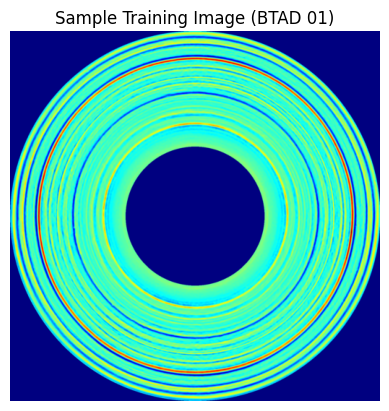

In [27]:
if not COMPARE_MODELS:
    # ==============================================================================
    # Load Data
    # ==============================================================================
    # --- 1. Dataset and DataLoader ---
    print("Setting up datasets and dataloaders...")
    # Example for MVTec DATASET_CAT_STR.lower() category
    # Ensure MVTEC_DATA_DIR points to the root of the MVTec AD dataset
    # and contains a DATASET_CAT_STR.lower() subdirectory.
    try:
        if USING_MVTEC:
          train_dataset = MVTecDataset(
              data_dir=MVTEC_DATA_DIR, category=DATASET_CAT_STR.lower(),
              split="train", img_size=IMG_SIZE
          )
          test_dataset = MVTecDataset(
              data_dir=MVTEC_DATA_DIR, category=DATASET_CAT_STR.lower(),
              split="test", img_size=IMG_SIZE
          )
        else:
          train_dataset = BTADDataset(
            data_dir=BTAD_DATA_DIR, category=DATASET_CAT_STR.lower(),
            split="train", img_size=IMG_SIZE
          )
          test_dataset = BTADDataset(
              data_dir=BTAD_DATA_DIR, category=DATASET_CAT_STR.lower(),
              split="test", img_size=IMG_SIZE
          )

        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **NUM_WORKERS_PARAM)
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, **NUM_WORKERS_PARAM)

        # Show a sample training image
        if len(train_dataset) > 0:
            sample_train_img = next(iter(train_dataloader))
            Utils.show_image(sample_train_img[0], title=f"Sample Training Image ({DATASET_STR} {DATASET_CAT_STR})")

    except Exception as e:
        print(f"Error setting up {DATASET_STR} Dataloader: {e}")
        train_dataloader = None # Prevent further errors
        test_dataloader = None

In [ ]:
# ==============================================================================
# Main script execution
# ==============================================================================
if not COMPARE_MODELS:
    print(f"Using device: {DEVICE}")

    # --- 2. Model Initialization ---
    print("\nInitializing models...")

    model = ViTAnomalyModelWithGMDN(
          img_size=IMG_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM, encoder_depth=NUM_LAYERS,
          num_heads=NUM_HEADS, mlp_hidden_dim=MLP_HIDDEN_DIM, norm_layer_type=CONF_STR.lower(),
          dyt_init_a=DYT_INIT_A, num_gaussians_gmdn=NUM_GAUSSIANS, use_mask=True
      ).to(DEVICE)

    print(f"ViT with {CONF_STR} and GMDN initialized.")
    #torch.autograd.set_detect_anomaly(True) #TODO IMPORTANTE DA TOGLIERE
    torch.cuda.empty_cache()

    # --- 3. Optimizer ---
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    if wandb.run:
      wandb.summary["optimizer"] = optimizer.__class__.__name__
    losses = list()

    # --- 4. Training Loop ---

    if train_dataloader and TRAIN_MODEL: # Only train if data is loaded
        print(f"\nStarting training for ViT-{CONF_STR} model...")

        training_start_time = time.time()
        for epoch in range(NUM_EPOCHS): # A few epochs for demonstration
            loss_vec, loss_component_list = train_one_epoch(model, train_dataloader, optimizer, epoch, NUM_EPOCHS)
            loss = np.mean(loss_vec)
            losses.append(loss)

            #we log all losses (total and each component)
            if wandb.run:
              for key, value in loss_component_list.items():
                  wandb.log({key + "_loss": np.mean(value)})

            #We log the reconstructions
            sample_images = next(iter(train_dataloader))
            if sample_images.size(1) == 1:
                  sample_images = torch.stack([sample_images, sample_images, sample_images]).squeeze(2).permute(1, 0, 2, 3)

            sample_images = sample_images.to(DEVICE)
            reconstructed_images, _, _, _, _ = model(sample_images)

            # Create comparison grid
            if wandb.run:
              comparison = torch.cat([sample_images[:4].cpu(), reconstructed_images[:4].cpu()])
              grid = torch_utils.make_grid(comparison, nrow=4)
              wandb.log({"reconstructions": wandb.Image(grid)})

            if epoch % 25 == 0 and epoch != 0: # Save every 25 epochs
                Utils.save_checkpoint({
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }, filename= os.path.join(MODEL_SAVE_DIR, f"vit_{CONF_STR.lower()}_epoch_training_{epoch}_{EXPERIMENT_NAME}_db_{DATASET_STR.lower()}.pth.tar"))


        #show loss plot
        Utils.plot_loss(losses, len(losses), title=f"ViT-{CONF_STR} Training Loss")

        # Save the model
        Utils.save_checkpoint({
            'epoch': NUM_EPOCHS,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, filename= os.path.join(MODEL_SAVE_DIR, FILENAME_STR))

        print(f"Training for ViT-{CONF_STR} finished.")
        training_end_time = time.time()
        print(f"Training took {training_end_time - training_start_time:.4f} seconds.")
        if wandb.run:
          wandb.summary["training_time"] = training_end_time - training_start_time
    else:
        print(f"Loading model from {MODEL_SAVE_DIR}...")
        Utils.load_checkpoint(os.path.join(MODEL_SAVE_DIR, f"vit_layernorm_epoch_LayerNorm-MVTEC_db_mvtec.pth.tar"), model)


Using device: cuda

Initializing models...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 226MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
ViT with LayerNorm and GMDN initialized.

Starting training for ViT-LayerNorm model...
Epoch [1/400], Batch [0/50], Loss: 840.5999
Epoch [1/400], Batch [10/50], Loss: 595.4732
Epoch [1/400], Batch [20/50], Loss: 434.9409
Epoch [1/400], Batch [30/50], Loss: 312.1317
Epoch [1/400], Batch [40/50], Loss: 196.4213
Epoch [1/400] completed. Average Training Loss: 407.1220
Epoch [2/400], Batch [0/50], Loss: 104.9981
Epoch [2/400], Batch [10/50], Loss: 27.9140
Epoch [2/400], Batch [20/50], Loss: -38.9324
Epoch [2/400], Batch [30/50], Loss: -94.1956
Epoch [2/400], Batch [40/50], Loss: -125.1083
Epoch [2/400] completed. Average Training Loss: -47.7961
Epoch [3/400], Batch [0/50], Loss: -137.2942
Epoch [3/400], Batch [10/50], Loss: -145.0351
Epoch [3/400], Batch [20/50], Loss: -150.2728
Epoch [3/400], Batch [30/50], Loss: -156.3784
Epoch [3/400], Batch [40/50], Loss: -162.0620
Epoch [3/400] completed. Average Tr

In [ ]:
# ==============================================================================
# Evaluation on Test Set of the Trained Model
# ==============================================================================

if not COMPARE_MODELS:
    if test_dataloader: # Only evaluate if data is loaded
        # Load best checkpoint before evaluation if saved
        # Utils.load_checkpoint("best_vit_{CONF_STR.lower()}_model.pth.tar", model_vit)

        print(f"\n Starting evaluation for ViT-{CONF_STR} model...")

        results = evaluate_model(model, test_dataloader)
        print(f"ViT-{CONF_STR} Evaluation Results: {results}")

        if wandb.run:
          for key, value in results.items():
              wandb.summary[key] = value
    else:
        print("\nSkipping evaluation due to dataloader issues.")

    print("\nProject script finished.")

In [ ]:
if not COMPARE_MODELS and NUM_EPOCHS >= 50 and TRAIN_MODEL:
    wandb.finish()
    if IS_COLAB: #disconnettiamo runtime
      runtime.unassign()
elif not COMPARE_MODELS and NUM_EPOCHS < 50 and TRAIN_MODEL: #poche epochs, stiamo in development, non disconnettiamo
    wandb.finish()

# Comparison between Different Models

In [ ]:
if COMPARE_MODELS:
    print("Comparing models...")
    wandb.init(
        project="CV_project",
        name="Compare_Models"
    )

    model_dyt_mvtec = ViTAnomalyModelWithGMDN(
        img_size=IMG_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM, encoder_depth=NUM_LAYERS,
        num_heads=NUM_HEADS, mlp_hidden_dim=MLP_HIDDEN_DIM,norm_layer_type="dyt", dyt_init_a=DYT_INIT_A,
        num_gaussians_gmdn=NUM_GAUSSIANS, use_mask=True
    )

    model_ln_mvtec = ViTAnomalyModelWithGMDN(
        img_size=IMG_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM, encoder_depth=NUM_LAYERS,
        num_heads=NUM_HEADS, mlp_hidden_dim=MLP_HIDDEN_DIM, norm_layer_type="layernorm", dyt_init_a=DYT_INIT_A,
        num_gaussians_gmdn=NUM_GAUSSIANS, use_mask=True
    )

    model_dyt_btad = ViTAnomalyModelWithGMDN(
        img_size=IMG_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM, encoder_depth=NUM_LAYERS,
        num_heads=NUM_HEADS, mlp_hidden_dim=MLP_HIDDEN_DIM, norm_layer_type="dyt", dyt_init_a=DYT_INIT_A,
        num_gaussians_gmdn=NUM_GAUSSIANS, use_mask=True
    )

    model_ln_btad = ViTAnomalyModelWithGMDN(
        img_size=IMG_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM, encoder_depth=NUM_LAYERS, num_heads=NUM_HEADS,
        mlp_hidden_dim=MLP_HIDDEN_DIM, norm_layer_type="layernorm", dyt_init_a=DYT_INIT_A,
        num_gaussians_gmdn=NUM_GAUSSIANS, use_mask=True
    )

    models_dict = {
        DYT_MODEL_NAME_MVTEC: model_dyt_mvtec,
        LN_MODEL_NAME_MVTEC: model_ln_mvtec,
        DYT_MODEL_NAME_BTAD: model_dyt_btad,
        LN_MODEL_NAME_BTAD: model_ln_btad
    }


    mvtec_test_dataset = MVTecDataset(
        data_dir=MVTEC_DATA_DIR, category=DATASET_CAT_STR.lower(),
        split="test", img_size=IMG_SIZE
    )
    btad_test_dataset = BTADDataset(
        data_dir=BTAD_DATA_DIR, category=DATASET_CAT_STR.lower(),
        split="test", img_size=IMG_SIZE
    )

    mvtec_test_dataloader = DataLoader(mvtec_test_dataset, batch_size=BATCH_SIZE, shuffle=False, **NUM_WORKERS_PARAM)
    btad_test_dataloader = DataLoader(btad_test_dataset, batch_size=BATCH_SIZE, shuffle=False, **NUM_WORKERS_PARAM)

    results = dict()

    for name, model in models_dict.items():

        model.to(DEVICE)
        Utils.load_checkpoint(os.path.join(MODEL_SAVE_DIR, name), model)

        time_start = time.time()

        if "mvtec" in name:
            result = evaluate_model(model, mvtec_test_dataloader)
        else:
            result = evaluate_model(model, btad_test_dataloader)

        time_end = time.time()

        print(f"{name} Evaluation Results: {result}")
        print(f"Model {name} took {time_end - time_start} seconds to evaluate")

        result["evaluation_time"] = time_end - time_start
        results[name] = result

        for key, value in result.items():
            wandb.summary[name + "_" + key] = value

        # Clear GPU memory
        del model
        torch.cuda.empty_cache()

    fig = Utils.visualize_model_results(results)
    wandb.summary["Model_Comparison"] = wandb.Image(fig)
    wandb.finish()

In [ ]:
# TODO controllare se funziona poi farlo brillare
def create_example_results():
    """
    Create an example results dictionary for demonstration.

    Returns:
    --------
    dict
        Example results dictionary
    """
    results = {
        "mvtec_resnet18": {
            "auroc": 0.923,
            "ap": 0.856,
            "f1_score": 0.789,
            "precision": 0.831,
            "recall": 0.752,
            "evaluation_time": 45.67
        },
        "mvtec_efficientnet": {
            "auroc": 0.945,
            "ap": 0.872,
            "f1_score": 0.802,
            "precision": 0.845,
            "recall": 0.764,
            "evaluation_time": 67.89
        },
        "mvtec_vit": {
            "auroc": 0.957,
            "ap": 0.891,
            "f1_score": 0.834,
            "precision": 0.867,
            "recall": 0.803,
            "evaluation_time": 120.45
        },
        "btad_resnet18": {
            "auroc": 0.887,
            "ap": 0.812,
            "f1_score": 0.743,
            "precision": 0.795,
            "recall": 0.698,
            "evaluation_time": 38.21
        },
        "btad_efficientnet": {
            "auroc": 0.912,
            "ap": 0.843,
            "f1_score": 0.775,
            "precision": 0.822,
            "recall": 0.734,
            "evaluation_time": 58.32
        },
        "btad_vit": {
            "auroc": 0.934,
            "ap": 0.865,
            "f1_score": 0.803,
            "precision": 0.851,
            "recall": 0.760,
            "evaluation_time": 110.78
        }
    }
    return results

# Example usage
if False:
    # Create example results
    results = create_example_results()

    # Generate visualization
    fig = Utils.visualize_model_results(results)

    # Save the figure
    fig.show()

    # If you want to display it (e.g., in a notebook)
    # plt.show()

    print("Visualization created and saved to 'model_evaluation_results.png'")

# TODO


- Fare il codice in modo che prenda i file e faccia solo evaluation ☑️☑️☑️
- Poter ristartare il training da un modello già salvato (per fine tunare)
- Scrivere blocchi di codice che valutano le performance con e senza Dynamic
 Tanh ☑️☑️☑️

* ⁠vedersi la loro funzione evaluation e capire perché fanno quella roba strana coi filtri gaussiani (visto ma ho ancora dubbi...)
*  ⁠⁠rivedersi i TODO in giro (rimossi un po' ☑️)
*  fottergli i plot fighi ☑️☑️☑️
- Calcolo SSIM diverso in loro repo ☑️☑️☑️

*   dare una letta accurata a tutto, magari capire bene come possiamo velocizzare il tutto, usando le einsum

-  sparse rapresentation per la mask attn (☑️ claude dice che se non mascheriamo >90% è inutile al cazzo)

*   ⁠⁠capire perché il digitCaps mi ha fatto castare tutto a .to(DEVICE) sennò dava errore ☑️☑️☑️

*   ⁠⁠Se pure loro fanno quelle threshold strana per classificare (simile ☑️☑️☑️)



# IMPROVING


- Decaying Noise ☑️ (Forse da tunare i coefficienti, bhooo)
- Parameter Init ☑️ (fallito miseramente lasciamo tutto com'è che ho quasi stirato)
- Transformer Decoder (Inutile se non hai tanti dati)
- Masked Self Attention random patches ☑️
- Aggiungere altre loss (☑️☑️, la Perceptual Loss in realtà peggiora, abbiamo provato LW SSIM)